<a href="https://colab.research.google.com/github/marcusborela/Aprendizado-Profundo-Unicamp/blob/main/Aula_9_Exerc%C3%ADcio_Marcus_Borela.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
nome = "Marcus Vinicius Borela de Castro"
print(f'Meu nome é {nome}')

Meu nome é Marcus Vinicius Borela de Castro


#  Exercício: Modelo de Linguagem com auto-atenção

Este exercício é similar ao da Aula 7, mas iremos agora treinar uma rede neural *com auto-atenção* para prever a próxima palavra de um texto, data as palavras anteriores como entrada. 

Na camada de auto-atenção, não se esqueça de implementar:
- Embeddings de posição
- Projeções lineares (WQ, WK, WV, WO)
- Conexões residuais
- Camada de feed forward (2-layer MLP)



O dataset usado neste exercício (BrWaC) possui um tamanho razoável e você vai precisar rodar seus experimentos com GPU.

Alguns conselhos úteis:
- **ATENÇÃO:** o dataset é bem grande. Não dê comando de imprimí-lo.
- Durante a depuração, faça seu dataset ficar bem pequeno, para que a depuração seja mais rápida e não precise de GPU. Somente ligue a GPU quando o seu laço de treinamento já está funcionando
- Não deixe para fazer esse exercício na véspera. Ele é trabalhoso.

# Preparação do ambiente

In [18]:
# iremos utilizar a biblioteca dos transformers para ter acesso ao tokenizador do BERT.
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importação dos pacotes

In [19]:
import collections
import itertools
import functools
import math
import random

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader


In [20]:
# from tqdm import tqdm_notebook
# from tqdm import tqdm

In [21]:
import time
import itertools

In [22]:
# Check which GPU we are using
!nvidia-smi

Wed Jun  1 16:01:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

## Fixando as seeds

In [23]:
def inicializa_seed(num_semente:int=123):
  """
  É recomendado reiniciar as seeds antes de inicializar o modelo, pois assim
  garantimos que os pesos vao ser sempre os mesmos.
  fontes de apoio: 
      http://nlp.seas.harvard.edu/2018/04/03/attention.html
      https://github.com/CyberZHG/torch-multi-head-attention/blob/master/torch_multi_head_attention/multi_head_attention.py#L15
  """
  random.seed(num_semente)
  np.random.seed(num_semente)
  torch.manual_seed(num_semente)
  #torch.cuda.manual_seed(num_semente)
  #Cuda algorithms
  #torch.backends.cudnn.deterministic = True 

In [24]:
inicializa_seed(123)

## Definindo Hiperparâmetros iniciais

In [25]:
def inicia_hparam()->dict:
  # Inicialização dos parâmetros
  hparam = {}
  hparam["num_workers_dataloader"] = 1
  hparam["device"] = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  if torch.cuda.is_available(): print(torch. cuda. get_device_name(hparam["device"]))    
  return hparam

In [26]:
hparam=inicia_hparam()

Tesla P100-PCIE-16GB


## Preparando para debug

https://zohaib.me/debugging-in-google-collab-notebook/

In [27]:
!pip install -Uqq ipdb
import ipdb
# %pdb off # desativa debug em exceção
# %pdb on  # ativa debug em exceção
# ipdb.set_trace(context=8)  para execução nesse ponto

In [28]:
# %xmode Verbose 
# %xmode Plain
# colocar %debug após ocorrer exception

In [29]:
torch.autograd.set_detect_anomaly(True)

In [30]:
import os

In [31]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Rastro (neptune.ai)

Gerado rastro da execução no Neptune (detalhes no artigo [Rastro-DM: Mineração de Dados com Rastro](https://revista.tcu.gov.br/ojs/index.php/RTCU/article/view/1664))


### Importação de libraries para Rastro

In [32]:
try:
  import neptune.new as neptune  
except ImportError:
  !pip install neptune-client
  raise Exception('Stopping RUNTIME! Please run again.')


In [33]:
try:
  from torchviz import make_dot 
except ImportError:
  !pip install torchviz
  from torchviz import make_dot 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=480a598295401fafbbeb3d12a7be22e9e606df1b1721a99f950fcdb7c569c5cb
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [34]:
import getpass
import copy
import time
import re
import tempfile
import os


In [35]:
import time


### Código Rastro

Busca implementar o rastro proposto em [Rastro-DM: Mineração de Dados com Rastro](https://revista.tcu.gov.br/ojs/index.php/RTCU/article/view/1664), autores Marcus Vinícius Borela de Castro e Remis Balaniuk, com o apoio da [solução Neptune](https://app.neptune.ai/)



In [36]:
def converte_optimizer_state_dict(parm_optimizer)-> dict:
  # return str(hparam['optimizer'])
  return parm_optimizer.state_dict()['param_groups'][0]

In [37]:
class NeptuneRastroRun():
    se_geracao_rastro = True 
    neptune_project = ""
    tag_contexto_rastro = ""
    neptune_api_token = ""

    def __init__(self, parm_params:dict,  parm_lista_tag:list = None):
      # print(f"NeptuneRastroRun.init: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_params `{parm_params} ")
      if self.__class__.se_geracao_rastro:      
        self.run_neptune = neptune.init(project=self.__class__.neptune_project, api_token=self.__class__.neptune_api_token, capture_hardware_metrics=True)
        self.run_neptune['sys/name'] = self.__class__.tag_contexto_rastro
        vparams = copy.deepcopy(parm_params)
        if "optimizer" in vparams:
          vparams["optimizer"] = converte_optimizer_state_dict(vparams["optimizer"])
        if 'criterion'  in vparams:
          vparams["criterion"] = str(vparams["criterion"])
        if 'scheduler'  in vparams:
          vparams["scheduler"] = str(type(vparams["scheduler"]))
        if 'device' in vparams:
          vparams['device'] = str(vparams["device"])
        self.device = vparams["device"]
        for tag in parm_lista_tag:
          self.run_neptune['sys/tags'].add(tag)
        self.run_neptune['parameters'] = vparams
        self.tmpDir = tempfile.mkdtemp()

    @property
    def run():
      return self.run_neptune

    @classmethod
    def ativa_geracao_rastro(cls):
     cls.se_geracao_rastro = True      

    @classmethod
    def def_contexto(cls):
     cls.se_geracao_rastro = True      

    @classmethod
    def desativa_geracao_rastro(cls):
     cls.se_geracao_rastro = False      

    @classmethod
    def retorna_status_geracao_rastro(cls):
     return cls.se_geracao_rastro      

    @classmethod
    def retorna_tag_contexto_rastro(cls):
     return cls.tag_contexto_rastro 

    @classmethod
    def inicia_contexto(cls, neptune_project, tag_contexto_rastro, neptune_api_token):
      assert '.' not in tag_contexto_rastro, "NeptuneRastroRun.init(): tag_contexto_rastro não pode possuir ponto, pois será usado para gravar nome de arquivo"      
      cls.neptune_api_token = neptune_api_token
      cls.tag_contexto_rastro = tag_contexto_rastro
      cls.neptune_project = neptune_project

    def salva_metrica(self, parm_metricas={}):
      #print(f"NeptuneRastroRun.salva_metrica: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_metricas:{parm_metricas} ")
      if self.__class__.se_geracao_rastro:
        for metrica, valor in parm_metricas.items(): 
          self.run_neptune[metrica].log(valor)
 
    def gera_grafico_modelo(self, loader_train, model):
      if self.__class__.se_geracao_rastro: 
        # efetuar um forward 
        """
        se dataloader devolver x e y:
        """
        x_, y_ = next(iter(loader_train))
        x_ = x_.to(self.device)
        outputs = model(x_)
        """
        # se dataloader devolver dict:
        dados_ = next(iter(loader_train))
        outputs = model(dados_['x'].to(self.device))
        #outputs = model(x_['input_ids'].to(self.device), x_['attention_mask'].to(self.device))
        """
        nome_arquivo = os.path.join(self.tmpDir, "modelo "+ self.__class__.tag_contexto_rastro + time.strftime("%Y-%b-%d %H:%M:%S"))
        make_dot(outputs, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render(nome_arquivo, format="png")
        self.run_neptune["parameters/model_graph"].upload(nome_arquivo+'.png')
        self.run_neptune['parameters/model'] = re.sub('<bound method Module.state_dict of ', '',str(model.state_dict))      



    def stop(self):
      if self.__class__.se_geracao_rastro:         
        self.run_neptune.stop()


### Definindo parâmetros para o rastro



In [38]:
NeptuneRastroRun.inicia_contexto('marcusborela/IA025', 'Aula 9 - Modelo de linguagem treino auto-regressivo',   getpass.getpass('Informe NEPTUNE_API_TOKEN'))
#NeptuneRastroRun.desativa_geracao_rastro()

Informe NEPTUNE_API_TOKEN··········


# Implementação do MyDataset

In [39]:
from typing import List

In [40]:
def tokenize(text: str, tokenizer):
    return tokenizer(text, return_tensors=None, add_special_tokens=False).input_ids


In [192]:
class MyDataset():
    def __init__(self, texts: List[str], tokenizer, max_seq_length: int, se_adiciona_eos:bool=True):
      """
      # concatena tokenizer.cls_token_id, tokenizer.sep_token_id 
      Cada conjunto x tem que ter pelo menos 2 palavras
      O primeiro conjunto começa com tokenizer.cls_token_id
      O último conjunto termina com tokenizer.sep_token_id
      """
      assert isinstance(texts,list), 'texts deve ser do tipo list'
      assert isinstance(texts[0],str), 'texts deve ser do tipo iterator of iterator of strings'
      assert isinstance(max_seq_length,int), 'max_seq_length deve ser do tipo int'
      assert max_seq_length > 3, 'max_seq_length deve ser maior do que 3'

      self.max_seq_length = max_seq_length
      x_data = []
      self.pad_token_id = tokenizer.pad_token_id
      self.cls_token_id = tokenizer.cls_token_id
      self.sep_token_id = tokenizer.sep_token_id
      self.qtd_sequencia = 0
      self.se_adiciona_eos=se_adiciona_eos
      self.tensor_pad_token_id = torch.tensor(tokenizer.pad_token_id, dtype=torch.long).unsqueeze(0)
      ndx_batch = 0
      tamanho_batch = 10
      num_sentencas = len(texts)
      while ndx_batch <= (num_sentencas - 1): # ndx começa do zero
        # if ndx_batch > 98:
        #  ipdb.set_trace(context=6)
        if se_adiciona_eos:
          batch_texto_numericalizado = tokenizer.batch_encode_plus(texts[ndx_batch:ndx_batch+tamanho_batch], return_attention_mask=False, return_token_type_ids = False, add_special_tokens=True).input_ids ## já retorna cls e sep
        else:
          batch_texto_numericalizado = tokenizer.batch_encode_plus(texts[ndx_batch:ndx_batch+tamanho_batch], return_attention_mask=False, return_token_type_ids = False, add_special_tokens=False).input_ids ## já retorna cls e sep
          [tk_sentenca.insert(0,tokenizer.cls_token_id) for tk_sentenca in batch_texto_numericalizado] # insere no inícios das sentença tokenizadas
        for cnt_texto, texto_numericalizado in enumerate(batch_texto_numericalizado): 
          assert texto_numericalizado[0] == self.cls_token_id, 'Numericalização sem começar com cls_token_id!'
          # assert texto_numericalizado[-1] == self.sep_token_id, 'Numericalização sem terminar com sep_token_id!'
          num_palavras_texto = len(texto_numericalizado)
          ndx_inicio_frase = 0
          if ndx_inicio_frase < num_palavras_texto - 2: # linha não tem apenas cls e sep
            while True:
              if ndx_inicio_frase < num_palavras_texto - 2: # conjunto não tem apenas token e sep
                if ndx_inicio_frase + self.max_seq_length <= num_palavras_texto: # não precisa completar com pad
                  x_data.append(texto_numericalizado[ndx_inicio_frase:ndx_inicio_frase + self.max_seq_length])
                else:
                  # completar padd
                  item = texto_numericalizado[ndx_inicio_frase:num_palavras_texto]
                  item = item + [self.pad_token_id for i in range(max_seq_length - (num_palavras_texto - ndx_inicio_frase))]
                  x_data.append(item)
                ndx_inicio_frase += max_seq_length
                self.qtd_sequencia += 1
              else:
                # ipdb.set_trace(context=6)
                break
              #if self.qtd_sequencia>36:
              #  print(f"self.qtd_sequencia {self.qtd_sequencia}")
              #  ipdb.set_trace(context=6)         
              #  if self.qtd_sequencia % 100 == 0:
              #      print(F'\tMontando Mydataset self.qtd_sequencia: {self.qtd_sequencia};  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')
        ndx_batch += tamanho_batch
        if ndx_batch % 1000 == 0:
            print(F'\tMontando Mydataset ndx_batch: {ndx_batch+1}; self.qtd_sequencia: {self.qtd_sequencia}; Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')
      print(F'\tVou converter lista para tensor;  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')
      self.x_tensor = torch.tensor(x_data).long()
      print(F'\tConvertido: lista para tensor;  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')


    def __len__(self):
      return self.qtd_sequencia

    def __getitem__(self, idx):
      #if idx > self.qtd_sequencia:
      #  raise Exception("Tentativa de ler além do limite")
      if idx == (self.qtd_sequencia - 1)  or (self.x_tensor[idx+1][0] == self.cls_token_id): # não tem continuação na próxima frase
        # calcular y com deslocamento da atual
        y_tensor_ret = torch.cat((self.x_tensor[idx][1:], self.tensor_pad_token_id),0)
      else: # tem continuação na próxima frase
        y_tensor_ret = torch.cat((self.x_tensor[idx][1:],self.x_tensor[idx+1][0].unsqueeze(0)),0) # para concatenar, não pode ser um tensor (escalar), mas [escalar]
      return self.x_tensor[idx], y_tensor_ret

Implementado dataset abaixo com CLS em todos os começos... E sem SEP!

Mas não houve tempo para testar impacto no modelo. 

In [ ]:
class MyDatasetComClsSemSep():
    def __init__(self, texts: List[str], tokenizer, max_seq_length: int):
      """
      # concatena tokenizer.cls_token_id, tokenizer.sep_token_id 
      Cada conjunto x tem que ter pelo menos 2 palavras
      O primeiro conjunto começa com tokenizer.cls_token_id
      O último conjunto termina com tokenizer.sep_token_id
      """
      assert isinstance(texts,list), 'texts deve ser do tipo list'
      assert isinstance(texts[0],str), 'texts deve ser do tipo iterator of iterator of strings'
      assert isinstance(max_seq_length,int), 'max_seq_length deve ser do tipo int'
      assert max_seq_length > 3, 'max_seq_length deve ser maior do que 3'

      self.max_seq_length = max_seq_length
      x_data = []
      self.pad_token_id = tokenizer.pad_token_id
      self.cls_token_id = tokenizer.cls_token_id
      self.sep_token_id = tokenizer.sep_token_id
      self.qtd_sequencia = 0
      self.se_adiciona_eos=se_adiciona_eos
      self.tensor_pad_token_id = torch.tensor(tokenizer.pad_token_id, dtype=torch.long).unsqueeze(0)
      ndx_batch = 0
      tamanho_batch = 10
      num_sentencas = len(texts)
      while ndx_batch <= (num_sentencas - 1): # ndx começa do zero
        # if ndx_batch > 98:
        #  ipdb.set_trace(context=6)
        batch_texto_numericalizado = tokenizer.batch_encode_plus(texts[ndx_batch:ndx_batch+tamanho_batch], return_attention_mask=False, return_token_type_ids = False, add_special_tokens=False).input_ids ## retorna sem cls e sep
        [tk_sentenca.insert(0,tokenizer.cls_token_id) for tk_sentenca in batch_texto_numericalizado] # insere cls nos inícios das sentença tokenizadas
        for cnt_texto, texto_numericalizado in enumerate(batch_texto_numericalizado): 
          assert texto_numericalizado[0] == self.cls_token_id, 'Numericalização sem começar com cls_token_id!'
          # assert texto_numericalizado[-1] == self.sep_token_id, 'Numericalização sem terminar com sep_token_id!'
          num_palavras_texto = len(texto_numericalizado)
          ndx_inicio_frase = 0
          if ndx_inicio_frase < num_palavras_texto - 2: # linha não tem apenas cls e sep
            while True:
              if ndx_inicio_frase < num_palavras_texto - 2: # conjunto não tem apenas token e sep
                if ndx_inicio_frase + self.max_seq_length <= num_palavras_texto: # não precisa completar com pad
                  x_data.append(texto_numericalizado[ndx_inicio_frase:ndx_inicio_frase + self.max_seq_length])
                else:
                  # completar padd
                  item = texto_numericalizado[ndx_inicio_frase:num_palavras_texto]
                  item = item + [self.pad_token_id for i in range(max_seq_length - (num_palavras_texto - ndx_inicio_frase))]
                  x_data.append(item)
                ndx_inicio_frase += max_seq_length
                self.qtd_sequencia += 1
              else:
                # ipdb.set_trace(context=6)
                break
              #if self.qtd_sequencia>36:
              #  print(f"self.qtd_sequencia {self.qtd_sequencia}")
              #  ipdb.set_trace(context=6)         
              #  if self.qtd_sequencia % 100 == 0:
              #      print(F'\tMontando Mydataset self.qtd_sequencia: {self.qtd_sequencia};  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')
        ndx_batch += tamanho_batch
        if ndx_batch % 1000 == 0:
            print(F'\tMontando Mydataset ndx_batch: {ndx_batch+1}; self.qtd_sequencia: {self.qtd_sequencia}; Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')
      print(F'\tVou converter lista para tensor;  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')
      self.x_tensor = torch.tensor(x_data).long()
      print(F'\tConvertido: lista para tensor;  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')


    def __len__(self):
      return self.qtd_sequencia

    def __getitem__(self, idx):
      #if idx > self.qtd_sequencia:
      #  raise Exception("Tentativa de ler além do limite")
      # calcular y com deslocamento da atual
      return self.x_tensor[idx], torch.cat((self.x_tensor[idx][1:], self.tensor_pad_token_id),0)

## Teste se sua implementação do MyDataset está correta

In [42]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased", do_lower_case=False)

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Dúvida
precisa?  do_lower_case=False
Resposta: não fez diferença

In [43]:
torch.tensor(tokenizer.pad_token_id, dtype=torch.long).unsqueeze(0)

tensor([0])

In [44]:
dummy_texts = ['Eu gosto de correr', 'Ela gosta muito de comer pizza']

In [45]:
tokenizer(dummy_texts, return_tensors=None, add_special_tokens=True, max_length=8, padding='max_length',truncation=False).input_ids

[[101, 3396, 10303, 125, 13239, 102, 0, 0],
 [101, 1660, 5971, 785, 125, 1847, 13779, 15616, 102]]

In [46]:
tokenizer.decode(101), tokenizer.decode(102)

('[ C L S ]', '[ S E P ]')

In [47]:
tokenize(dummy_texts, tokenizer)

[[3396, 10303, 125, 13239], [1660, 5971, 785, 125, 1847, 13779, 15616]]

In [48]:
tokenizer.batch_encode_plus(["Ela gosta muito de comer pizza mas está de dieta agora"]).input_ids

[[101,
  1660,
  5971,
  785,
  125,
  1847,
  13779,
  15616,
  449,
  698,
  125,
  14559,
  2535,
  102]]

In [49]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [50]:
tokenizer.cls_token_id, tokenizer.sep_token_id , tokenizer.pad_token_id , tokenizer.special_tokens_map 

(101,
 102,
 0,
 {'cls_token': '[CLS]',
  'mask_token': '[MASK]',
  'pad_token': '[PAD]',
  'sep_token': '[SEP]',
  'unk_token': '[UNK]'})

In [51]:
tokenizer.batch_encode_plus(tokenizer.all_special_tokens)

{'input_ids': [[101, 100, 102], [101, 102, 102], [101, 0, 102], [101, 101, 102], [101, 103, 102]], 'token_type_ids': [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], 'attention_mask': [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]]}

In [52]:
dummy_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, max_seq_length=9)
dummy_loader = DataLoader(dummy_dataset, batch_size=6, shuffle=False)
assert len(dummy_dataset) == 2
print('passou no assert de tamanho do dataset')

	Vou converter lista para tensor;  Momento: [2022-Jun-01 16:02:13]
	Convertido: lista para tensor;  Momento: [2022-Jun-01 16:02:13]
passou no assert de tamanho do dataset


In [53]:
first_batch_input, first_batch_target = next(iter(dummy_loader))

In [54]:
first_batch_input, first_batch_target

(tensor([[  101,  3396, 10303,   125, 13239,   102,     0,     0,     0],
         [  101,  1660,  5971,   785,   125,  1847, 13779, 15616,   102]]),
 tensor([[ 3396, 10303,   125, 13239,   102,     0,     0,     0,     0],
         [ 1660,  5971,   785,   125,  1847, 13779, 15616,   102,     0]]))

In [55]:
correct_first_batch_input = torch.LongTensor(
    [[  101,  3396, 10303,   125, 13239,     102,     0,     0,     0],
     [  101,  1660,  5971,   785,   125,  1847, 13779, 15616,     102]])

correct_first_batch_target = torch.LongTensor(
    [[ 3396, 10303,   125, 13239,     102,     0,     0,     0,     0],
     [ 1660,  5971,   785,   125,  1847, 13779, 15616,    102,     0]])


In [56]:
assert torch.equal(first_batch_input, correct_first_batch_input)
assert torch.equal(first_batch_target, correct_first_batch_target)

print('Passou no assert de dataset.')

Passou no assert de dataset.


# Carregamento do dataset 

Iremos usar uma pequena amostra do dataset [BrWaC](https://www.inf.ufrgs.br/pln/wiki/index.php?title=BrWaC) para treinar e avaliar nosso modelo de linguagem.

In [57]:
import io

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
#@title Seleção datasets
hparam['num_sentenca_train'] = 249800 #@param [800, 249800] {type:'raw'}
hparam['num_sentenca_valid'] = 100 # 100
hparam['num_sentenca_test'] = 100 # 100
hparam['max_seq_length'] = 50 #@param [9, 50, 100] {type:'raw'}
total_sentencas = hparam['num_sentenca_train']+hparam['num_sentenca_valid']+hparam['num_sentenca_test']
print(f"total_sentencas: {total_sentencas}")
print(f"hparam['max_seq_length']: {hparam['max_seq_length']}")


total_sentencas: 250000
hparam['max_seq_length']: 50


In [340]:
prefixo_nome_diretorio= '/content/drive/My Drive/ia025/aula9/'

infixo_nome= 'dataset_max_seq_'+ str(hparam['max_seq_length'])+'_text_'
print(prefixo_nome_diretorio + infixo_nome)

/content/drive/My Drive/ia025/aula9/dataset_max_seq_50_text_


In [61]:
#@title Boolean fields
datasets_carregados_previamente = True #@param {type:"boolean"}

print(datasets_carregados_previamente)

True


In [62]:
if datasets_carregados_previamente:
  with open(prefixo_nome_diretorio+infixo_nome+str(hparam['num_sentenca_test'])+'_test.pt','rb') as f:
    buffer = io.BytesIO(f.read())
  test_dataset = torch.load(buffer)
  with open(prefixo_nome_diretorio+infixo_nome+str(hparam['num_sentenca_valid'])+'_valid.pt','rb') as f:
    buffer = io.BytesIO(f.read())
  valid_dataset = torch.load(buffer)
  with open(prefixo_nome_diretorio+infixo_nome+str(hparam['num_sentenca_train'])+'_train.pt','rb') as f:
    buffer = io.BytesIO(f.read())
  train_dataset = torch.load(buffer)    

In [ ]:
if not datasets_carregados_previamente:
  !wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula9/sample-1gb.txt
  texts = open('sample-1gb.txt').readlines() 
  assert total_sentencas <= len(texts), f"total sentencas deve ser <= len(texts)"
  # texts = texts[:total]  

  # carga total para treino:
  # hparam['num_sentenca_train'] = total_sentencas - (hparam['num_sentenca_valid'] + hparam['num_sentenca_test'])
  # train_texts = texts[:hparam['num_sentenca_train'] ]
  # hparam['num_sentenca_train'] = len(train_texts)
  # carga parcial para treino:
  
  #ipdb.set_trace(context=6)
  


File ‘sample-1gb.txt’ already there; not retrieving.



In [63]:
if not datasets_carregados_previamente:
  valid_texts = texts[-(hparam['num_sentenca_valid'] + hparam['num_sentenca_test']):-hparam['num_sentenca_test']]
  test_texts = texts[-hparam['num_sentenca_test']:]  
  print("carregando valid_dataset")
  valid_dataset = MyDataset(texts=valid_texts, tokenizer=tokenizer, max_seq_length=hparam['max_seq_length'])
  torch.save(valid_dataset, prefixo_nome_diretorio+infixo_nome+str(hparam['num_sentenca_valid'])+'_valid.pt')

  print("carregando test_dataset")
  test_dataset = MyDataset(texts=test_texts, tokenizer=tokenizer, max_seq_length=hparam['max_seq_length'])
  torch.save(test_dataset, prefixo_nome_diretorio+infixo_nome+str(hparam['num_sentenca_test'])+'_test.pt')

In [64]:
if not datasets_carregados_previamente:
  assert hparam['num_sentenca_train'] <=  total_sentencas - (hparam['num_sentenca_valid'] + hparam['num_sentenca_test']), f"Dados de treino não podem conter dados de validação/teste"
  train_texts = texts[:hparam['num_sentenca_train'] ]

  print("carregando train_dataset")
  train_dataset = MyDataset(texts=train_texts, tokenizer=tokenizer, max_seq_length=hparam['max_seq_length'])
  torch.save(train_dataset, prefixo_nome_diretorio+infixo_nome+str(hparam['num_sentenca_train'])+'_train.pt')

  drive.flush_and_unmount()
  print('All changes made in this colab session should now be visible in Drive.')
  

In [65]:
hparam['train_size'] = len(train_dataset) 
hparam['valid_size'] = len(valid_dataset) 
hparam['test_size'] = len(test_dataset) 


print(f"training examples: {hparam['train_size']}")
print(f"valid examples: {hparam['valid_size']}")
print(f"test examples: {hparam['test_size']}")





training examples: 5711874
valid examples: 2694
test examples: 1535


max_seq_length=9, train_senteces = 800

* valid examples: 14755 (penúltimos 100)
* test examples: 8302 (últimos 100)
* training examples: 104175

max_seq_length=50, train_senteces = 249800
* training examples: 5711874
* valid examples: 2694
* test examples: 1535

max_seq_length=100, train_senteces = 249800
* training examples: 2915362
* valid examples: 1370
* test examples: 788





# Choosing Sequence Length

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
if not datasets_carregados_previamente: #dados carregados
  for dados in (test_texts, valid_texts, train_texts):
    tokens = tokenizer.batch_encode_plus(dados, return_attention_mask=False, return_token_type_ids = False).input_ids
    token_lens = [len(x) for x in tokens]
    sns.histplot(token_lens, stat='count', binwidth=50, kde=True)
    plt.xlim([0, 1000])
    plt.xlabel('Token count')
    plt.title(f'Sequence length base de dados')

# Modelo Self-attention, decoder-only 
  
  Language Model trainning

## Teoria

### Figuras

Fonte imagens abaixo material do curso

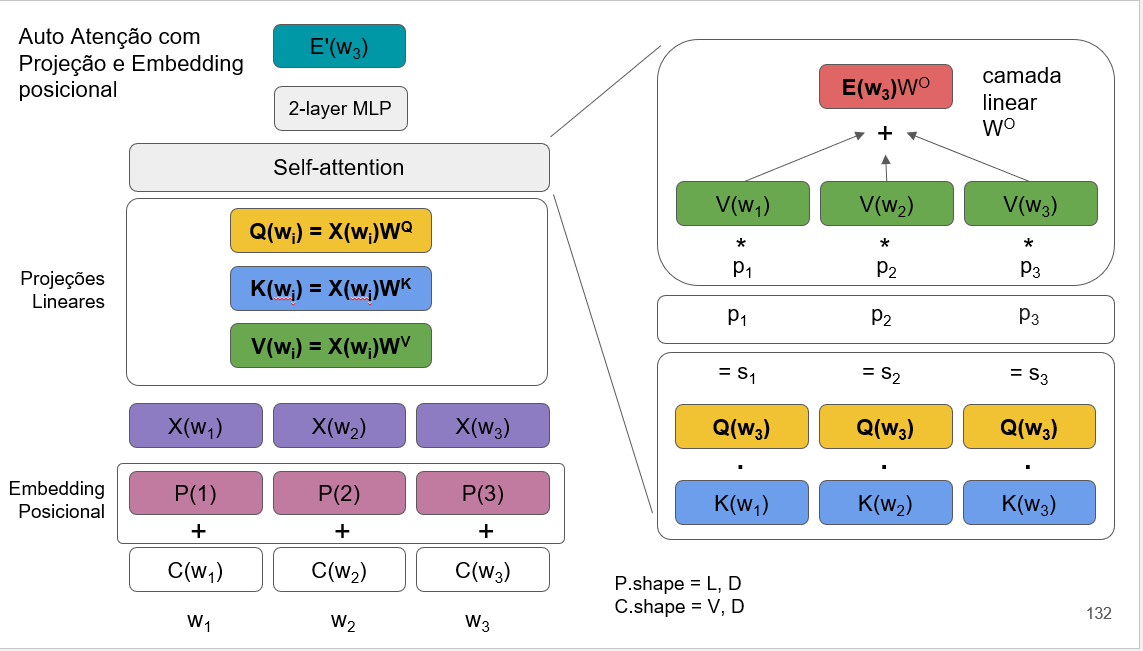

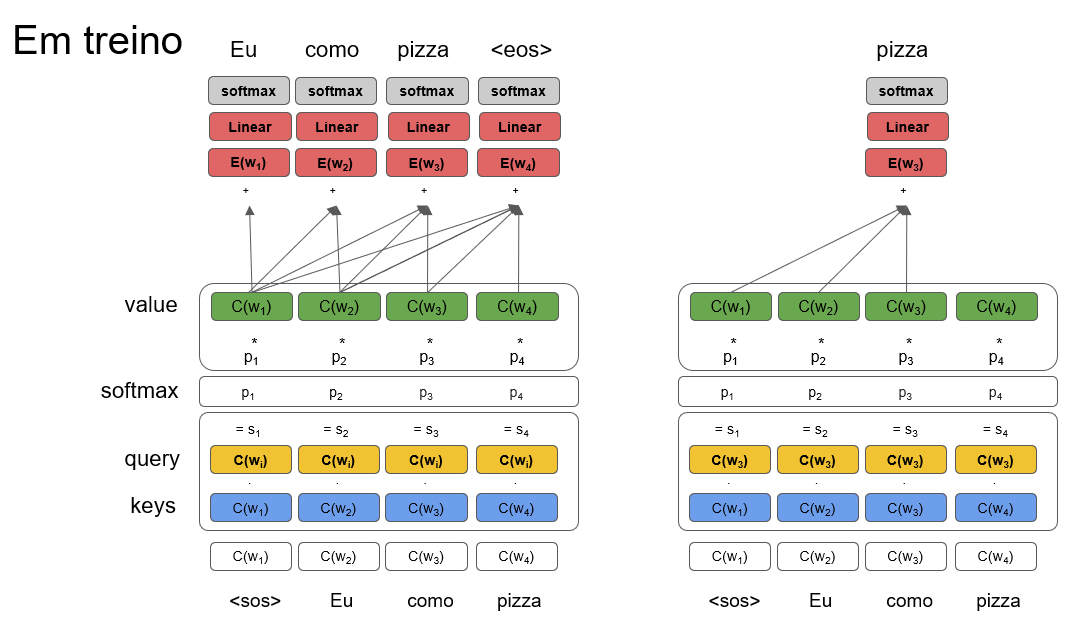



Fonte imagens abaixo: https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853#:~:text=Decoder%20Self%2DAttention&text=of%20each%20word.-,This%20is%20fed%20to%20all%20three%20parameters%2C%20Query%2C%20Key%2C,for%20each%20word%20as%20well.

End-to-end Multi-head Attention

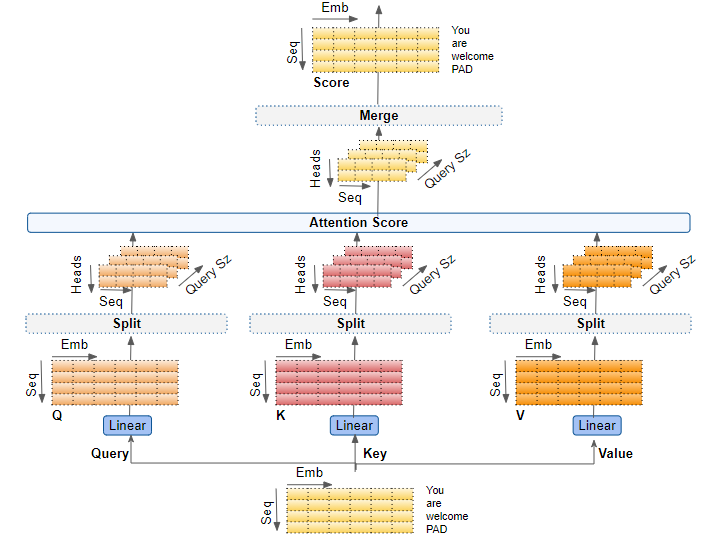

Decoder self attention

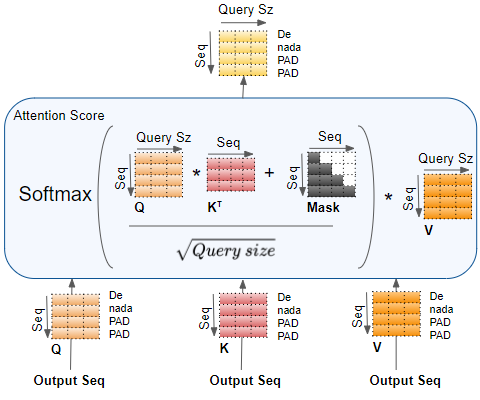

Calculando Attention 

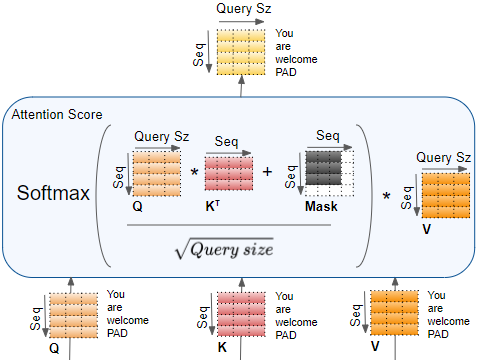

Detalhes

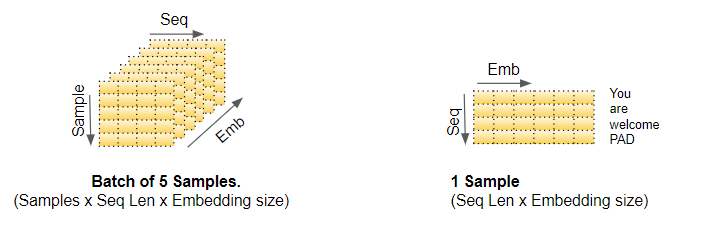

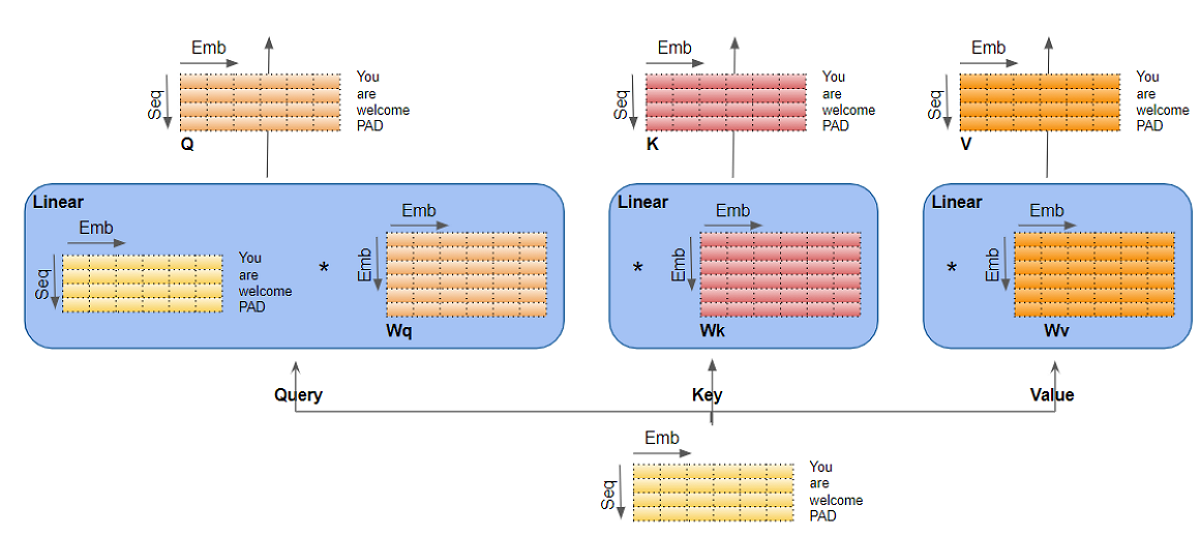

Subcamadas em uma camada

Fonte: https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch/notebook

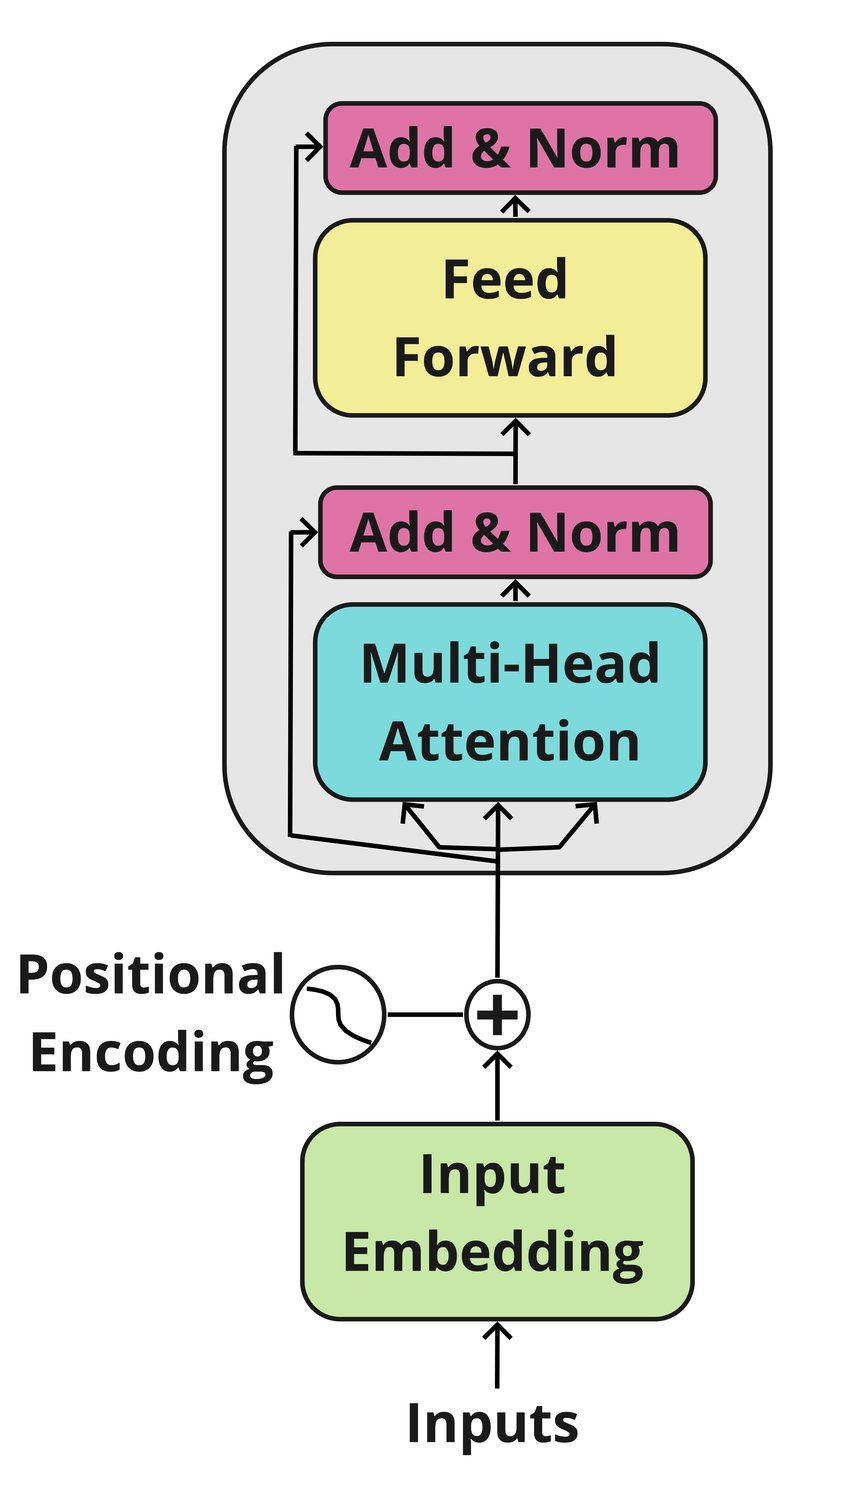

### Verificando implementação no Pytorch

**[torch.nn.TransformerDecoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoderLayer.html)**

Modelo tende a evoluir (próximas aulas) para essa layer

> (d_model, nhead, dim_feedforward=2048, dropout=0.1, activation=<function relu>, layer_norm_eps=1e-05, batch_first=False, norm_first=False, device=None, dtype=None)[SOURCE]

> TransformerDecoderLayer is made up of self-attn, multi-head-attn and feedforward network. This standard decoder layer is based on the paper “Attention Is All You Need”. Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in Neural Information Processing Systems, pages 6000-6010. Users may modify or implement in a different way during application.


x = torch.nn.TransformerDecoderLayer(d_model=768, nhead=1)

x

Parâmetros da função: MultiheadAttentionForwardFuncOptions(
*   int64_t embed_dim_to_check, 
*   int64_t num_heads, 
*   Tensor in_proj_weight, 
*   Tensor in_proj_bias, 
*   Tensor bias_k, 
*   Tensor bias_v, 
*   bool add_zero_attn, 
*   double dropout_p, 
*   Tensor out_proj_weight, 
*   Tensor out_proj_bias)

## Classes

In [307]:
class TransformerLayer(torch.nn.Module):


    def __init__(self, vocab_size:int, max_seq_length:int, embed_dim:int, 
                 pad_token_id: int, # n_layers: int=2,
                 dim_feedforward:int=256, 
                 ind_activation_function:str='gelu',  initializer_range:float=0.02,
                 # se_aplica_peso_posicao:bool=True,
                 prop_dropout_feedforward1:float=0.1, 
                 prop_dropout_feedforward2:float=0.1, prop_dropout_headattn:float=0.1,
                 se_bias_kvo:bool=False, se_scale_attn_weights:bool=False, verbose=False):
      """
      Implements the TransformerLayer with Self-attention and feed forward."

      Args:
          vocab_size (int): Size of the input vocabulary.
          max_seq_length (int): Size of the sequence to consider as context for prediction.
          embed_dim (int): Dimension of the embedding layer for each word in the context.
          n_layers (int): number of self-attention layers.
          dim_feedforward (int): Size of the hidden layer.
          pad_token_id (int): id of the pad token that will be ignored in the attention.
   
      Fontes de apoio:
        https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch/notebook


      """
      # Escreva seu código aqui.
      assert vocab_size==29794, f'Para aproveitar tokenizador do BERTimbau vocab_size deve ser 768 e não {vocab_size}'      
      assert ind_activation_function in ('relu','gelu'), f'ind_activation_function deve ser um dos valores: (relu,gelu) e não {ind_activation_function}'
      assert max_seq_length in [9, 50, 100],  f'max_seq_length deve ser [9, 50, 100] (datasets pré-carregado para esse valor!) e não {max_seq_length}'      

      super().__init__()
      self.mask_triangular = torch.tril(torch.ones(max_seq_length, max_seq_length)).unsqueeze(0) 
      self.se_bias_kvo = se_bias_kvo
      self.max_seq_length = max_seq_length
      self.embed_dim = embed_dim
      self.vocab_size = vocab_size
      self.dim_feedforward = dim_feedforward
      self.verbose = verbose
      self.ind_activation_function = ind_activation_function
      self.max_seq_length = max_seq_length
      self.prop_dropout_feedforward1 = prop_dropout_feedforward1 # The dropout ratio for the feedforward
      self.prop_dropout_feedforward2 = prop_dropout_feedforward2 # The dropout ratio for the feedforward
      self.prop_dropout_headattn = prop_dropout_headattn # The dropout ratio for the attention
      self.initializer_range = initializer_range # The standard deviation of the truncated_normal_initializer for initializing all weight matrices.
      self.se_scale_attn_weights = se_scale_attn_weights # Scale attention weights by dividing by sqrt(..
      self.pad_token_id = pad_token_id
        
      self.query_matrix = nn.Linear(self.embed_dim , self.embed_dim ,bias=False)  # 
      self.key_matrix = nn.Linear(self.embed_dim  , self.embed_dim, bias=self.se_bias_kvo)
      self.value_matrix = nn.Linear(self.embed_dim ,self.embed_dim , bias=self.se_bias_kvo)
      self.out_matrix = nn.Linear(self.embed_dim ,self.embed_dim, bias=self.se_bias_kvo) 
      self.layer1 = nn.Linear(self.embed_dim, self.dim_feedforward, bias=True)
      self.layer2 = nn.Linear(self.dim_feedforward,self.embed_dim, bias=True)

      self.norm_headattn = nn.LayerNorm(embed_dim,  eps=1e-05, elementwise_affine=True) 
      self.norm_feedforward = nn.LayerNorm(self.embed_dim,  eps=1e-05, elementwise_affine=True)
      self.dropout_headattn = nn.Dropout(prop_dropout_headattn)
      self.dropout_feedforward1 = nn.Dropout(prop_dropout_feedforward1)
      self.dropout_feedforward2 = nn.Dropout(prop_dropout_feedforward2)


      # Fonte caderno do colega Pedro Gengo
      # 1, max_seq_length, max_seq_length
      # precisa ser bool para mask_fill
      self.mask_triangular = torch.tril(torch.ones(max_seq_length, max_seq_length)).unsqueeze(0).bool().to(hparam['device'])
      self.init_weights()

    def init_weights(self):
      inicializa_seed(123)
      nn.init.uniform_(self.query_matrix.weight, -self.initializer_range, self.initializer_range)
      nn.init.uniform_(self.key_matrix.weight, -self.initializer_range, self.initializer_range)
      nn.init.uniform_(self.value_matrix.weight, -self.initializer_range, self.initializer_range)
      nn.init.uniform_(self.out_matrix.weight, -self.initializer_range, self.initializer_range)
      nn.init.uniform_(self.layer1.weight, -self.initializer_range, self.initializer_range)
      # if self.verbose: print(f"self.layer1.weight.shape {self.layer1.weight.shape}\n {self.layer1.weight}")
      nn.init.zeros_(self.layer1.bias)
      nn.init.uniform_(self.layer2.weight, -self.initializer_range, self.initializer_range)
      nn.init.zeros_(self.layer2.bias)
      # if self.verbose: print(f"self.layer2.weight.shape {self.layer2.weight.shape}\n {self.layer2.weight}")
      # nn.init.zeros_(self.layer2.bias)
      if self.se_bias_kvo:
        nn.init.zeros_(self.key_matrix.bias)
        nn.init.zeros_(self.value_matrix.bias)
        nn.init.zeros_(self.out_matrix.bias)

    def feed_forward(self, entrada):
      """
      Sequência retirada do pytorch (https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html#TransformerDecoderLayer.forward)
          self.dropout3(self.linear2(self.dropout(self.activation(self.linear1(x)))))

      """
      batch_size, seq_length, embed_dim = entrada.shape[0], entrada.shape[1], entrada.shape[2]
      if self.verbose: print(f"\nCálculo feed_forward")
      if self.verbose: print(f"entrada.shape: (batch_size, seq_length, seq_length) {entrada.shape}\n  {entrada}")
      # entrada = entrada.view(batch_size, seq_length * embed_dim )
      if self.verbose: print(f"[após view] entrada.shape: (batch_size, seq_length * seq_length) {entrada.shape}\n  {entrada}")
      saida = self.layer1(entrada)
      if self.verbose: print(f"apos layer1 saida.shape: (batch_size, seq_length, seq_length) {saida.shape}\n  {saida}")
      if self.ind_activation_function == 'relu':
        saida = torch.nn.functional.relu(saida)
      else:
        saida = torch.nn.functional.gelu(saida)
      if self.verbose: print(f"apos ativacao saida.shape: (batch_size, seq_length, seq_length) {saida.shape}\n  {saida}")
      saida = self.dropout_feedforward1(saida)
      if self.verbose: print(f"apos dropout_feedforward1 saida.shape: (batch_size, seq_length, seq_length) {saida.shape}\n  {saida}")
      saida = self.layer2(saida)
      if self.verbose: print(f"apos layer2 saida.shape: (batch_size, seq_length, seq_length) {saida.shape}\n  {saida}")
      saida = self.dropout_feedforward2(saida)
      if self.verbose: print(f"apos dropout_feedforward2 saida.shape: (batch_size, seq_length, seq_length) {saida.shape}\n  {saida}")
      return saida


    def auto_atencao(self, query, key, value, mask_padding):

      batch_size, seq_length, embed_dim = query.shape[0], query.shape[1], query.shape[2]

      # if self.verbose: print(f"query/key/value.shape: (batch_size, seq_length, embed_dim)  {query.shape}\n  {query}")
      if self.verbose: print(f"torch.transpose(key, 1, 2).shape: (batch_size,  embed_dim, seq_length) {torch.transpose(key, 1, 2).shape}\n  {torch.transpose(key, 1, 2)}")

      # AUTO-ATENÇÃO
      if self.verbose: print(f"\nCálculo do produto vetorial: query x key")
      produto_vetorial = torch.matmul(query, key.transpose(1, 2))

      assert (batch_size, seq_length, seq_length) == produto_vetorial.shape, f"produto_vetorial tem shape { produto_vetorial.shape} e deveria ter {(batch_size, seq_length, seq_length)} "
      if self.verbose: print(f"produto_vetorial.shape: (batch_size, seq_length, seq_length) {produto_vetorial.shape}\n  {produto_vetorial}")

      #divising by square root of key dimension
      if self.se_scale_attn_weights:
        produto_vetorial = produto_vetorial / math.sqrt(self.embed_dim) 
        if self.verbose: print(f"[se_scale_attn_weights] produto_vetorial.shape: (batch_size, seq_length, seq_length) {produto_vetorial.shape}\n  {produto_vetorial}")


      # B, L -> B, 1, L -> B, L, L
      mask_padding_expanded = mask_padding[:, None, :].expand_as(produto_vetorial)
      if self.verbose: print(f":: mask_padding_expanded.shape: (batch_size, seq_length, seq_length) {mask_padding_expanded.shape}\n  {mask_padding_expanded} ")
      produto_vetorial.masked_fill_(~mask_padding_expanded, float('-inf'))  # B, L, L

      # L, L -> 1, L, L -> B, L, L
      mask_triangular_expanded = self.mask_triangular.expand_as(produto_vetorial)
      if self.verbose: print(f":: mask_triangular_expanded.shape: (batch_size, seq_length, seq_length) {mask_triangular_expanded.shape}\n  {mask_triangular_expanded} ")
      produto_vetorial.masked_fill_(~mask_triangular_expanded, float('-inf'))  # B, L, L

      if self.verbose: print(f"\nCálculo do softmax do produto vetorial (probs) ")
      probs = torch.nn.functional.softmax(produto_vetorial,dim=-1)  # shape = B, L, L

      assert (batch_size, seq_length, seq_length) == probs.shape, f"probs tem shape {probs.shape} e deveria ter {(batch_size, seq_length, seq_length)} "
      if self.verbose: print(f":: probs.shape: (batch_size, seq_length, seq_length) {probs.shape}\n  {probs} ")

      if self.verbose: print(f"\nCálculo da soma ponderada do softmax (probs) pelos embeddings (de value)  ")
      embed_sequencia_com_att = torch.matmul(probs, value)           

      assert (batch_size, seq_length, embed_dim) == embed_sequencia_com_att.shape, f"embed_sequencia_com_att tem shape (batch_size, seq_length, embed_dim) {embed_sequencia_com_att.shape} e deveria ter {(batch_size, seq_length, seq_length)} "   
      if self.verbose: print(f":: embed_sequencia_com_att.shap  (batch_size, seq_length, embed_dim): {embed_sequencia_com_att.shape}\n  {embed_sequencia_com_att} ")


      embed_sequencia_com_att = embed_sequencia_com_att.transpose(1, 2).contiguous().reshape(batch_size, seq_length, -1)  # B, L, D
      #concatenated output
      # output = embed_sequencia_com_att.transpose(1,2).contiguous().view(batch_size, seq_length, self.embed_dim)  
      # if self.verbose: print(f"após transpose shape (batch_size, seq_length, embed_dim)  {output.shape}\n  {output}")

      output = self.out_matrix(embed_sequencia_com_att) 
      if self.verbose: print(f"após out_matrix: (batch_size, seq_length, embed_dim)  {output.shape}\n  {output}")

      output = self.dropout_headattn(output)
      if self.verbose: print(f"após dropout_headattn: (batch_size, seq_length, embed_dim)  {output.shape}\n  {output}")


      return output


      """
      if self.verbose: print(f"\nCálculo da média dos embeddings com atenção")
      #embed_sequencia_com_att[batch_token_ids == padding_idx,:] = 0
      # E = E.nansum(dim=1)
      embed_sequencia_com_att_mean = nanmean(embed_sequencia_com_att, dim = 1)
      # embed_sequencia_com_att_mean = embed_sequencia_com_att.mean(dim = 1)
      #  similar a: embed_sequencia_com_att_mean = torch.div(embed_sequencia_com_att.sum(axis=1), torch.tensor(seq_length)) 
      assert (batch_size, embed_dim) == embed_sequencia_com_att_mean.shape, f"embed_sequencia_com_att_mean tem shape (batch_size, embed_dim) { embed_sequencia_com_att_mean.shape} e deveria ter {(batch_size, embed_dim)} "
      if self.verbose: print(f":: embed_sequencia_com_att_mean.shape (batch_size, embed_dim): {embed_sequencia_com_att_mean.shape}\n  {embed_sequencia_com_att_mean} ")
      return embed_sequencia_com_att_mean
      """

    def forward(self, query, key, value, mask_padding):
      """
      Args:
          inputs is a LongTensor of shape (batch_size, seq_length)

        batch_token_ids.shape = batch_size, seq_length

        Após embed: batch_size, seq_length, embed_dim

        batch_token_ids = stack(C(w1), C(w2), C(w3))
        # batch_size = tamanho do minibatch 
        # seq_length = comprimento da sequência 
        # embed_dim = dimensão do embeddings 
        Q = K = V = X   # batch_size,seq_length,D

        scores = matmul(Q, KT) # shape = batch_size,seq_length,seq_length
        probs = softmax(scores, dim=-1) # batch_size,seqseq_lenlen, seq_length
                E = matmul(probs, V)  # shape = batch_size,seq_length,embed_dim
        return E
      """
      batch_size, seq_length, embed_dim = query.shape[0], query.shape[1], query.shape[2]

      assert seq_length == self.max_seq_length, f" seq_length deve ser = self.max_seq_length::  {seq_length} <> {self.max_seq_length}"

      # PROJEÇÕES LINEARES
      query_x = self.query_matrix(query)   
      key_x = self.key_matrix(key)       
      value_x = self.value_matrix(value)
      if self.verbose: print(f"query_x.shape: (batch_size, seq_length, embed_dim)  {query_x.shape}\n  {query_x}")
      if self.verbose: print(f"key_x.shape: (batch_size, seq_length, embed_dim)  {key_x.shape}\n  {key_x}")
      if self.verbose: print(f"value_x.shape: (batch_size, seq_length, embed_dim)  {value_x.shape}\n  {value_x}")

      # AUTO-ATENÇÃO
      saida_headattn = self.auto_atencao(query_x, key_x, value_x, mask_padding)
      if self.verbose: print(f"\n[após attn] saida_headattn.shape: (batch_size, seq_length, embed_dim)  {saida_headattn.shape}\n  {saida_headattn}[após attn] ")

      # ADD&NORM 
      saida_headattn = saida_headattn + query
      if self.verbose: print(f"após saida_headattn+=query: .shape: (batch_size, seq_length, embed_dim)  {saida_headattn.shape}\n  {saida_headattn}[após attn] ")
      saida_headattn = self.norm_headattn(saida_headattn)
      if self.verbose: print(f"após norm_headattn saida_headattn.shape: (batch_size, seq_length, embed_dim)  {saida_headattn.shape}\n  {saida_headattn}[após attn] ")




      # FEED-FORWARD
      saida_feed_forward = self.feed_forward(saida_headattn)
      if self.verbose: print(f"após feed_forward saida_feed_forward.shape: (batch_size, seq_length, embed_dim)  {saida_feed_forward.shape}\n  {saida_feed_forward}[após attn] ")

      saida_feed_forward += saida_headattn # Residual


      # NORM - não dá para ADD pois a saída do decoder é todo o vocab e o saida_headattn tem shape diferente
      logits = self.norm_feedforward(saida_feed_forward)
      if self.verbose: print(f"após norm_feedforward:  logits.shape: (batch_size, seq_length, embed_dim)  {logits.shape}\n  {logits}[após attn] ")

      logits = logits * mask_padding[:, :, None]

      # mean_embeddings = E.sum(1) / torch.clamp(mask.sum(1)[:, None], min=1)


      return logits



In [308]:
class LanguageModel(torch.nn.Module):


    def __init__(self, vocab_size:int, max_seq_length:int, embed_dim:int, 
                 pad_token_id: int, n_layers: int=2, dim_feedforward:int=256, 
                 ind_activation_function:str='gelu',  initializer_range:float=0.02,
                 se_aplica_peso_posicao:bool=True, prop_dropout_feedforward1:float=0.1, 
                 prop_dropout_feedforward2:float=0.1, prop_dropout_headattn:float=0.1,
                 se_bias_kvo:bool=False, se_scale_attn_weights:bool=True, verbose=False):
      """
      Implements the Self-attention, decoder-only."

      Args:
          vocab_size (int): Size of the input vocabulary.
          max_seq_length (int): Size of the sequence to consider as context for prediction.
          embed_dim (int): Dimension of the embedding layer for each word in the context.
          n_layers (int): number of self-attention layers.
          dim_feedforward (int): Size of the hidden layer.
          pad_token_id (int): id of the pad token that will be ignored in the attention.
   
      Fontes de apoio:
        https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch/notebook


      """
      # Escreva seu código aqui.
      assert vocab_size==29794, f'Para aproveitar tokenizador do BERTimbau vocab_size deve ser 768 e não {vocab_size}'      
      assert ind_activation_function in ('relu','gelu'), f'ind_activation_function deve ser um dos valores: (relu,gelu) e não {ind_activation_function}'
      assert max_seq_length in [9, 50, 100],  f'max_seq_length deve ser [9, 50, 100] (datasets pré-carregado para esse valor!) e não {max_seq_length}'      

      super().__init__()
      self.max_seq_length = max_seq_length
      self.embed_dim = embed_dim
      self.vocab_size = vocab_size
      self.pad_token_id = pad_token_id
      self.n_layers = n_layers
      self.verbose = verbose
      self.se_aplica_peso_posicao = se_aplica_peso_posicao
      self.initializer_range = initializer_range # The standard deviation of the truncated_normal_initializer for initializing all weight matrices.

        
      self.embedding_layer = nn.Embedding(self.vocab_size, self.embed_dim)       
      #       
      if self.se_aplica_peso_posicao:
        self.peso_posicao = torch.nn.Linear(self.embed_dim, self.max_seq_length, bias=False)
        # self.peso_posicao = nn.Parameter(torch.zeros(self.embed_dim, self.max_seq_length, dtype=torch.float32), requires_grad=True)  
        # if self.verbose: print(f"self.peso_posicao.shape {self.peso_posicao.shape}\n {self.peso_posicao}")

      self.layers = nn.ModuleList([TransformerLayer( \
          vocab_size, max_seq_length, embed_dim, 
                 pad_token_id, dim_feedforward, 
                 ind_activation_function, initializer_range,
                 prop_dropout_feedforward1, prop_dropout_feedforward2, prop_dropout_headattn,
                 se_bias_kvo, se_scale_attn_weights, verbose)
       for i in range(n_layers)])
      self.classificador_head = nn.Linear(self.embed_dim,self.vocab_size, bias=False)
      self.init_weights()

    def init_weights(self):
      inicializa_seed(123)
      nn.init.uniform_(self.embedding_layer.weight, -self.initializer_range, self.initializer_range)      
      nn.init.uniform_(self.classificador_head.weight, -self.initializer_range, self.initializer_range)      
      if self.se_aplica_peso_posicao:
        nn.init.uniform_(self.peso_posicao.weight,  -self.initializer_range, self.initializer_range) 
        # if self.verbose: print(f"self.peso_posicao.shape {self.peso_posicao.shape}\n {self.peso_posicao}")

    def forward(self, batch_token_ids):
      """
      Args:
          inputs is a LongTensor of shape (batch_size, seq_length)

        batch_token_ids.shape = batch_size, seq_length

        Após embed: batch_size, seq_length, embed_dim

        batch_token_ids = stack(C(w1), C(w2), C(w3))
        # batch_size = tamanho do minibatch 
        # seq_length = comprimento da sequência 
        # embed_dim = dimensão do embeddings 
      """
      batch_size, seq_length = batch_token_ids.shape
      assert seq_length == self.max_seq_length, f" seq_length deve ser = self.max_seq_length::  {seq_length} <> {self.max_seq_length}"

      mask_padding = batch_token_ids != self.pad_token_id
      if self.verbose: print(f"mask_padding.shape: (batch_size, seq_length) {mask_padding.shape}\n  {mask_padding}")
      # Truncamento para eliminar PADs desnecessários.
      # max_len = mask_padding.sum(1).max()
      # batch_token_ids = batch_token_ids[:, :max_len]
      # mask_padding = mask_padding[:, :max_len]

      if self.verbose: print(f"batch_token_ids.shape: (batch_size, seq_length) {batch_token_ids.shape}\n  {batch_token_ids}")
      if self.verbose: print(f"batch_size {batch_size}  seq_length {seq_length} embed_dim  {self.embed_dim}")
      assert seq_length <= self.max_seq_length, f" seq_length deve ser <= self.max_seq_length::  {seq_length} <> {self.max_seq_length}"

      x = self.embedding_layer(batch_token_ids)  
      if self.verbose: print(f"Após embedding_layer x.shape: (batch_size, seq_length, embed_dim) {x.shape}\n  {x}")
      if self.se_aplica_peso_posicao:
        # Add positional embeddings
        if self.verbose: print(f"self.peso_posicao.weight[None, :seq_length, :].shape: (batch_size, seq_length, embed_dim, embed_dim)  {self.peso_posicao.weight[None, :seq_length, :].shape}\n  {self.peso_posicao.weight[None, :seq_length, :]}")       
        x += self.peso_posicao.weight[None, :seq_length, :]
        if self.verbose: print(f"Após somar embedding+pos_embed: x.shape: (batch_size, seq_length, embed_dim)  {x.shape}\n  {x}")


      for layer in self.layers:
          x = layer(x,x,x, mask_padding)

      retorno=self.classificador_head(x)
      return retorno



## Perplexidade


In [68]:
inicializa_seed(123)

In [69]:
def perplexity(logits, target, ignore_token_id: int):
    """
    Computes the perplexity.

    Args:
        logits: a FloatTensor of shape (batch_size, seq_length, vocab_size)
        target: a LongTensor of shape (batch_size, seq_length)

    Returns:
        A float corresponding to the perplexity
    """
    # ipdb.set_trace(context=4) 
    logits = logits.reshape(-1, logits.shape[-1])
    target = target.reshape(-1)
    loss = nn.functional.cross_entropy(logits, target, reduction='mean', ignore_index=ignore_token_id)

    # calculando perplexidade 
    return torch.exp(loss)  
    

## Teste do modelo e a função de perplexidade com um exemplo

In [270]:
!nvidia-smi

Thu Jun  2 00:29:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    34W / 250W |   3443MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [271]:
hparam['vocab_size']=tokenizer.vocab_size
hparam['embed_dim']=3
hparam['dim_feedforward']=256
hparam['ind_activation_function']='gelu'
hparam['n_layers'] = 2
#documentação
hparam['num_classes']=hparam['vocab_size']

hparam

{'amsgrad': False,
 'batch_size': 50,
 'criterion': CrossEntropyLoss(),
 'decrease_factor_lr': 1e-06,
 'device': device(type='cuda', index=0),
 'dim_feedforward': 256,
 'drop_last': True,
 'early_stop': 570,
 'embed_dim': 3,
 'eval_every_steps': 57,
 'fator_corte_loss_maximo': 1,
 'ind_activation_function': 'gelu',
 'learning_rate': 0.0001,
 'lista_tag_rastro_experiencia_treino': ['embed_dim 128',
  'dim_feedforward 256',
  'ind_activation_function gelu',
  'batch_size 50',
  'learning_rate 0.0001',
  'weight_decay 0.0001',
  'amsgrad False',
  'decrease_factor_lr 1e-06',
  'max_examples 1142374.8',
  'eval_every_steps 57'],
 'max_examples': 1142374.8,
 'max_seq_length': 50,
 'n_layers': 2,
 'num_classes': 29794,
 'num_epochs': 0.2,
 'num_params': 7897600,
 'num_sentenca_test': 100,
 'num_sentenca_train': 249800,
 'num_sentenca_valid': 100,
 'num_workers_dataloader': 0,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     initial_lr:

In [272]:
sample_x, sample_y = next(iter(DataLoader(valid_dataset,batch_size=1)))
sample_x = sample_x.to(hparam['device'])
print(f"sample_y.shape: {sample_y.shape}, sample_y: {sample_y}")
print(f"sample_x.shape: {sample_x.shape}, sample_x: {sample_x}")


sample_y.shape: torch.Size([1, 50]), sample_y: tensor([[10150, 22281,   221, 21873,  5838, 18899,  1182,   529,  9035,   125,
          6139,   170,   146,  3204,   221,   939,   119,  1643,   997,   291,
           325,  5943, 14355, 22287,   118,   176,   320, 21626, 22323,   122,
           123,   117,   202,  7847,   117,   222,  2442,  4648,   117,  3983,
           706,  7569,  2854,   122, 11026,   123, 16276,  2564,   351,  1115]])
sample_x.shape: torch.Size([1, 50]), sample_x: tensor([[  101, 10150, 22281,   221, 21873,  5838, 18899,  1182,   529,  9035,
           125,  6139,   170,   146,  3204,   221,   939,   119,  1643,   997,
           291,   325,  5943, 14355, 22287,   118,   176,   320, 21626, 22323,
           122,   123,   117,   202,  7847,   117,   222,  2442,  4648,   117,
          3983,   706,  7569,  2854,   122, 11026,   123, 16276,  2564,   351]],
       device='cuda:0')


In [273]:
!nvidia-smi

Thu Jun  2 00:29:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    34W / 250W |   3443MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [274]:
hparam

{'amsgrad': False,
 'batch_size': 50,
 'criterion': CrossEntropyLoss(),
 'decrease_factor_lr': 1e-06,
 'device': device(type='cuda', index=0),
 'dim_feedforward': 256,
 'drop_last': True,
 'early_stop': 570,
 'embed_dim': 3,
 'eval_every_steps': 57,
 'fator_corte_loss_maximo': 1,
 'ind_activation_function': 'gelu',
 'learning_rate': 0.0001,
 'lista_tag_rastro_experiencia_treino': ['embed_dim 128',
  'dim_feedforward 256',
  'ind_activation_function gelu',
  'batch_size 50',
  'learning_rate 0.0001',
  'weight_decay 0.0001',
  'amsgrad False',
  'decrease_factor_lr 1e-06',
  'max_examples 1142374.8',
  'eval_every_steps 57'],
 'max_examples': 1142374.8,
 'max_seq_length': 50,
 'n_layers': 2,
 'num_classes': 29794,
 'num_epochs': 0.2,
 'num_params': 7897600,
 'num_sentenca_test': 100,
 'num_sentenca_train': 249800,
 'num_sentenca_valid': 100,
 'num_workers_dataloader': 0,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     initial_lr:

In [301]:
hparam['embed_dim'] = 3

In [310]:
model = LanguageModel(
    vocab_size=hparam['vocab_size'],
    max_seq_length=hparam['max_seq_length'],
    embed_dim=hparam['embed_dim'],
    pad_token_id = tokenizer.pad_token_id, 
    n_layers=hparam['n_layers'],      
    dim_feedforward=hparam['dim_feedforward'],
    ind_activation_function=hparam['ind_activation_function'],
    verbose=True
).to(hparam['device'])


In [311]:
saida = model(sample_x)

mask_padding.shape: (batch_size, seq_length) torch.Size([1, 50])
  tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True]], device='cuda:0')
batch_token_ids.shape: (batch_size, seq_length) torch.Size([1, 50])
  tensor([[  101, 10150, 22281,   221, 21873,  5838, 18899,  1182,   529,  9035,
           125,  6139,   170,   146,  3204,   221,   939,   119,  1643,   997,
           291,   325,  5943, 14355, 22287,   118,   176,   320, 21626, 22323,
           122,   123,   117,   202,  7847,   117,   222,  2442,  4648,   117,
          3983,   706,  7569,  2854,   122, 11026,   123, 16276,  2564,   351]],
       device='cuda:0')
batch_size 1  seq_length 50 embed_dim  3
Após embedding_layer x.shape: (batch_

In [312]:
saida[0]


tensor([[ 1.3712e-03, -1.3486e-02, -7.7049e-04,  ..., -3.3788e-02,
         -7.1172e-03, -1.6691e-02],
        [-5.2509e-05, -1.3933e-02, -6.5531e-03,  ..., -6.3084e-03,
         -6.5480e-03, -1.6624e-02],
        [ 1.4114e-03, -2.4356e-02, -5.5643e-03,  ..., -4.0290e-02,
         -1.2270e-02, -2.9693e-02],
        ...,
        [-1.3592e-03,  2.4957e-02,  6.0429e-03,  ...,  3.9590e-02,
          1.2525e-02,  3.0390e-02],
        [ 1.2217e-03, -8.7105e-03,  8.1949e-04,  ..., -2.8366e-02,
         -4.7809e-03, -1.0922e-02],
        [-7.2080e-04,  2.2914e-02,  7.6138e-03,  ...,  2.6087e-02,
          1.1211e-02,  2.7679e-02]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [313]:
saida.shape

torch.Size([1, 50, 29794])

In [314]:
assert saida.shape[2] == hparam['vocab_size'], "Saída[2] deveria ser do tamanho do vocabulário"
assert saida.shape[1] == hparam['max_seq_length'], "Saída[1] deveria ser do tamanho de max_seq_length"

In [315]:
del model


In [316]:
del saida

In [317]:
del sample_x, sample_y

In [318]:
!nvidia-smi

Thu Jun  2 00:49:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    34W / 250W |   3445MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### teste perplexidade

In [319]:
hparam['embed_dim'] = 64
hparam

{'amsgrad': False,
 'batch_size': 50,
 'criterion': CrossEntropyLoss(),
 'decrease_factor_lr': 1e-06,
 'device': device(type='cuda', index=0),
 'dim_feedforward': 256,
 'drop_last': True,
 'early_stop': 570,
 'embed_dim': 64,
 'eval_every_steps': 57,
 'fator_corte_loss_maximo': 1,
 'ind_activation_function': 'gelu',
 'learning_rate': 0.0001,
 'lista_tag_rastro_experiencia_treino': ['embed_dim 128',
  'dim_feedforward 256',
  'ind_activation_function gelu',
  'batch_size 50',
  'learning_rate 0.0001',
  'weight_decay 0.0001',
  'amsgrad False',
  'decrease_factor_lr 1e-06',
  'max_examples 1142374.8',
  'eval_every_steps 57'],
 'max_examples': 1142374.8,
 'max_seq_length': 50,
 'n_layers': 2,
 'num_classes': 29794,
 'num_epochs': 0.2,
 'num_params': 7897600,
 'num_sentenca_test': 100,
 'num_sentenca_train': 249800,
 'num_sentenca_valid': 100,
 'num_workers_dataloader': 0,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     initial_lr

In [320]:
model = LanguageModel(
    vocab_size=hparam['vocab_size'],
    max_seq_length=hparam['max_seq_length'],
    embed_dim=hparam['embed_dim'],
    n_layers=hparam['n_layers'],      
    pad_token_id = tokenizer.pad_token_id,
    dim_feedforward=hparam['dim_feedforward'],
    ind_activation_function=hparam['ind_activation_function'],
    verbose=False
).to(hparam['device'])


In [321]:
!nvidia-smi

Thu Jun  2 00:49:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    34W / 250W |   3445MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [322]:
# para localizar visualmente registro com padding
#for i in range(0, 110, 1):
#  print(i, sample_y[i])

if hparam['max_seq_length'] == 9:
  n_examples = 1000
  ndx_sentenca_com_padding = 669
elif hparam['max_seq_length'] == 50:
  n_examples = 100
  ndx_sentenca_com_padding = 97  
elif hparam['max_seq_length'] == 100:
  n_examples = 50
  ndx_sentenca_com_padding = 48 
else:
  raise Exception("Não há índices documentados") 
sample_x, sample_y = next(iter(DataLoader(train_dataset, batch_size=n_examples)))  
sample_x = sample_x.to(hparam['device'])
sample_y = sample_y.to(hparam['device'])
logits = model(sample_x)


In [323]:
logits.shape

torch.Size([100, 50, 29794])

In [324]:
sample_y.shape

torch.Size([100, 50])

In [325]:
print("Analisando tratamento de sentenças com padding")
print(f"sample_y[{ndx_sentenca_com_padding}] = {sample_y[ndx_sentenca_com_padding]}") # sentença com padding
print(f"sample_x[{ndx_sentenca_com_padding}] = {sample_x[ndx_sentenca_com_padding]}") # sentença com padding
print(f"logits[{ndx_sentenca_com_padding}] = {logits[ndx_sentenca_com_padding]}") # sentença com padding



Analisando tratamento de sentenças com padding
sample_y[97] = tensor([  173, 17326,   122, 16791,   122,  5686,   173, 16791,   119,  8922,
          180,  1327,  9813,   232,   122,   125, 16791,   171, 11952,   117,
          173,   710,  1033,   119,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
       device='cuda:0')
sample_x[97] = tensor([16891,   173, 17326,   122, 16791,   122,  5686,   173, 16791,   119,
         8922,   180,  1327,  9813,   232,   122,   125, 16791,   171, 11952,
          117,   173,   710,  1033,   119,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
       device='cuda:0')
logits[97] = tensor([[ 0.0086,  0.0794,  0.1920,  ..., -0.1288,  0.0032,  0.0927],
        [ 

In [326]:
model.pad_token_id

0

In [327]:
my_perplexity = perplexity(logits=logits, target=sample_y, ignore_token_id=model.pad_token_id)


print(f'correct initial perplexity: {tokenizer.vocab_size}')
print(f'my perplexity:              {int(my_perplexity)}')


correct initial perplexity: 29794
my perplexity:              29995


In [328]:
del model
del sample_x
del sample_y 
del logits

# Treinamento e Validação

## Funções auxiliares ao treinamento

In [329]:
def validation_step(input, target, parm_model):
    logits = parm_model(input)
    logits = logits.reshape(-1, logits.shape[-1])
    target = target.reshape(-1)
    loss = nn.functional.cross_entropy(logits, target, ignore_index=parm_model.pad_token_id)
    return loss.item()


In [330]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

A weight decay penalty of 10−4 was used in the Brown experiments and a weight decay of 10−5 was used in the APNews experiments  (not applied to bias)

fonte: https://raberrytv.wordpress.com/2017/10/29/pytorch-weight-decay-made-easy/

In [331]:
def add_param_weight_decay(net, l2_value, skip_list=()):
 decay, no_decay = [], []
 for name, param in net.named_parameters():
  # if not param.requires_grad: continue # frozen weights		            
  if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list: no_decay.append(param)
  else: decay.append(param)
 return [{'params': no_decay, 'weight_decay': 0.}, {'params': decay, 'weight_decay': l2_value}]

In [332]:
def gera_tag_rastro_experiencia_treino(parm_aula:str, hparam:dict)->str:
  lista_tag = []
  lista_chaves = ['embed_dim', 'dim_feedforward', 'ind_activation_function',  'batch_size', 'learning_rate', 'weight_decay', 'amsgrad', 'decrease_factor_lr', 'max_examples', 'eval_every_steps']
  for chave in lista_chaves:
    tag = f"{chave} {hparam[chave]}"
    lista_tag.append(tag)
  return lista_tag

In [ ]:
def treina_modelo (parm_model, parm_loader_train, parm_loader_valid, parm_loader_test, hparam:dict, parm_tags_rastro:list, parm_se_apenas_uma_validacao:bool=False, parm_verbose:bool = True, parm_intervalo_print = 10):
  """
  """
  rastro_neptune = NeptuneRastroRun(hparam, parm_lista_tag=parm_tags_rastro)
  try:
    train_losses = []
    n_examples = 0
    step_avaliacao = 0
    best_perplexidade_validacao = float('inf')
    best_step = 0
    history = []
    parm_model.eval()
    with torch.no_grad():
        valid_ppl = np.exp(np.average([
            validation_step(input_tmp.to(hparam['device']), target_tmp.to(hparam['device']), parm_model)
            for input_tmp, target_tmp in parm_loader_valid]))
    metrica_rastro = {"valid/perplexidade": valid_ppl}  
    history.append(metrica_rastro)
    rastro_neptune.salva_metrica(metrica_rastro)
    print(f'hparam: {hparam}')
    print(f'Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")} Métricas iniciais em validação: {metrica_rastro} Serão treinadas {hparam["max_examples"]} amostras')

    time_inicio_treino = time.time()
    ultimo_step_treinado = 0
    se_continua_execucao = True
    parm_model.train()
    num_step_avaliacao_extra = 0 # código não necessário: colocado por precaução para não perder execuçaõ longa. Retirar depois.
    while n_examples < hparam['max_examples'] and se_continua_execucao:
        # for qtd_param_update, (input, target) in enumerate(tqdm(parm_loader_train, desc=f"Training {100*n_examples/hparam['max_examples']:.3f}%", leave=False)):  
        for qtd_param_update, (input, target) in enumerate(parm_loader_train):  
        # for qtd_param_update in range(hparam['max_examples']):  
            # input, target = next(iter(parm_loader_train))
            ultimo_step_treinado += 1 
            logits = parm_model(input.to(hparam['device']))   


            logits = logits.reshape(-1, logits.shape[-1])
            target = target.reshape(-1).to(hparam['device'])
            loss = nn.functional.cross_entropy(logits, target, ignore_index=parm_model.pad_token_id)

            hparam['optimizer'].zero_grad()            
            loss = torch.nn.functional.cross_entropy(logits, target)
            # loss = hparam['criterion'](logits, target) * hparam['fator_corte_loss']   # copiando ideia do colega Pedro_Gengo; adicional ao weight-decay
            fator_corte_loss = max(hparam['fator_corte_loss_maximo'], n_examples/hparam['max_examples'])
            loss = hparam['criterion'](logits, target) * fator_corte_loss   # ajustando para diminuir a redução na loss quando perto do fim do treino
            loss.backward()
            hparam['optimizer'].step()
            hparam['scheduler'].step()  # DÚVIDA: melhor fazer por step treino ou por step validação?  Esse último não impactou mudança.              
            loss_batch = loss.item()/fator_corte_loss # desfazendo fator_corte_loss para não refletir na perplexidade
            train_losses.append(loss_batch) 
            n_examples += len(input)  # Increment of batch size

            if ultimo_step_treinado % hparam['eval_every_steps'] == 0:
                train_ppl = np.exp(np.average(train_losses))
                parm_model.eval()
                with torch.no_grad():
                    valid_ppl = np.exp(np.average([
                        validation_step(input_tmp.to(hparam['device']), target_tmp.to(hparam['device']), parm_model)
                        for input_tmp, target_tmp in parm_loader_valid]))

                train_losses = []

                metrica_rastro = {"train/perplexidade": train_ppl,
                                  "train/loss": loss_batch, 
                                  "train/n_examples": n_examples, 
                                  "train/learning_rate": hparam["optimizer"].param_groups[1]["lr"],
                                  "valid/perplexidade": valid_ppl}  
                history.append(metrica_rastro)
                rastro_neptune.salva_metrica(metrica_rastro)
                if parm_intervalo_print > 0:
                    if (ultimo_step_treinado)%(parm_intervalo_print*hparam['eval_every_steps']) == 0: 
                        print(f'Step: {ultimo_step_treinado} Amostras:{n_examples:d}  {100*n_examples/hparam["max_examples"]:.3f}%  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")} lr: {hparam["optimizer"].param_groups[1]["lr"]:.5e} Train loss: {loss_batch:.4f} perplexidade: {train_ppl:.4f} Validação perplexidade: {valid_ppl:.4f} ')
                
                # Salvando o melhor modelo de acordo com a loss de validação
                if valid_ppl < best_perplexidade_validacao:
                    best_model_dict = parm_model.state_dict()
                    # torch.save(parm_model.state_dict(), 'best_model' + NeptuneRastroRun.retorna_tag_contexto_rastro() + '.pt')
                    best_perplexidade_validacao = valid_ppl
                    best_step = ultimo_step_treinado
                    # print('best model')
                elif hparam['early_stop'] <= (ultimo_step_treinado - best_step):
                    if 'se_tem_unfreeze_early_stop' in hparam and hparam['se_tem_unfreeze_early_stop']:
                        if not parm_model.embedding_layer.weight.requires_grad:
                            # critério antigo: (100*n_examples / hparam['max_examples']) > hparam['percent_unfreeze_embeddings'] and not
                            # ipdb.set_trace(context=4)                    
                            # https://stackoverflow.com/questions/55640836/how-does-one-dynamically-add-new-parameters-to-optimizers-in-pytorch
                            parm_model.unfreeze_embeddings()
                            print('unfreeze embeddings')    
                            num_step_avaliacao_extra = 0           
                        else: # concede novo prazo para early stop
                            if num_step_avaliacao_extra > 3 * (hparam['early_stop']/hparam['eval_every_steps']):
                                print(f"Parando por critério de early_stop no step {ultimo_step_treinado} num_step_avaliacao_extra {num_step_avaliacao_extra} sendo best_step {best_step} e ealy_stop {hparam['early_stop']}")
                                se_continua_execucao = False
                                break
                            else:
                                num_step_avaliacao_extra += 1
                    else:
                        print(f"Parando por critério de early_stop no step {ultimo_step_treinado} sendo best_step {best_step} e ealy_stop {hparam['early_stop']}")
                        se_continua_execucao = False
                        break
                if parm_se_apenas_uma_validacao:
                    se_continua_execucao = False
                    break
                parm_model.train()


            if n_examples >= hparam['max_examples']:              
                break    
            
            # apenas para teste da lógica, tratar um batch por época


    # calculando tempo gasto e médio por step
    tempo_treino = time.time() - time_inicio_treino   
    rastro_neptune.run_neptune["tempo_treino"].log(tempo_treino)
    rastro_neptune.run_neptune["tempo_treino_por_step"].log(tempo_treino/ultimo_step_treinado)
    print(f"Tempo gasto total {tempo_treino:9.5f}, steps: {ultimo_step_treinado}, tempo por step {tempo_treino/ultimo_step_treinado:9.5f}")

    print(f'Final: Step: {ultimo_step_treinado} Amostras:{n_examples:d}  {100*n_examples/hparam["max_examples"]:.3f}%  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")} lr:{hparam["optimizer"].param_groups[1]["lr"]:.5e} Train loss: {loss_batch:.4f} Train perplexidade: {train_ppl:.4f} Validação perplexidade: {valid_ppl:.4f} ')

    rastro_neptune.run_neptune["valid/best_step"].log(best_step)


    parm_model.load_state_dict(best_model_dict)
    parm_model.to(hparam['device'])
    with torch.no_grad():
        test_ppl = np.exp(np.average([
            validation_step(input_tmp.to(hparam['device']), target_tmp.to(hparam['device']), parm_model)
            for input_tmp, target_tmp in parm_loader_test
        ]))


    metrica_rastro = {"test/perplexidade": test_ppl}      
    print(f" Resultado com dados de teste para modelo salvo no step {best_step}: {metrica_rastro}")
    rastro_neptune.salva_metrica(metrica_rastro)
    rastro_neptune.gera_grafico_modelo(parm_loader_train, parm_model)    

    path_modelo = f'{prefixo_nome_diretorio}best_model_len_{hparam["max_seq_length"]}_pplx_{int(test_ppl)}_em_{time.strftime("[%Y-%b-%d %H:%M:%S]")}.pt'
    torch.save(parm_model, path_modelo)    
    print(f"modelo salvo em {path_modelo}")


    gera_texto(parm_model, hparam['max_seq_length'], hparam['device'] )

  finally:
    rastro_neptune.stop()


  return {"perplexidade_test":test_ppl, "perplexidade_treino":train_ppl, "best_perplexidade_validacao":best_perplexidade_validacao,  "best_step": best_step} #, "best_model_dict": best_model_dict}

**Parameters for inference de um GPT-2 - evolução futura**

*   temperature (float) - Lower (below 1) makes the model more confident 
and less random. Higher values make generated text more random.
*   top_k (int) - How many tokens it considers when generating. 0 to 
deactivate
*   top_p (float) - only considers tokens from the top X% of confidences
*   beams (int) - How many tokens out should we consider
*   do_sample (bool) - If True, randomness is introduced in selection

In [361]:
def gera_texto(model, max_seq_length, device, prompt:str= 'Eu gosto de comer pizza pois me faz muito'):
  model.eval()
  max_output_tokens = 8
  assert (len(prompt) + max_output_tokens) <= max_seq_length, f"Rotina precisa ser ajustada para tratar qualquer tamanho de sentença de entrada {len(prompt)} e qualquer tamanho de max_length {max_output_tokens} que limita a soma a max_seq_length {max_seq_length}"
  dummy_texts = [prompt]
  
  """
  Versão com tensor em construção
  ipdb.set_trace(context=4) 
  input_ids = tokenizer.batch_encode_plus(dummy_texts, return_attention_mask=False, return_token_type_ids = False, add_special_tokens=False, return_tensors='pt').input_ids ## já retorna cls e sep
  tensor_cls_token_id = torch.tensor(tokenizer.cls_token_id, dtype=torch.long).unsqueeze(0)
  input_ids = torch.cat((tensor_cls_token_id, input_ids[:-1]),0)
  """
  
  eval_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, max_seq_length=max_seq_length, se_adiciona_eos= False)
  input_ids, _ = next(iter(DataLoader(eval_dataset,batch_size=1)))
  input_ids = input_ids.to(device)   # Usamos apenas os últimos <max_seq_length> tokens como entrada para o modelo.
  ndx_ultima_palavra = torch.nonzero(input_ids[0], as_tuple =False)[-1][0].item()
  
  for _ in range(max_output_tokens):
    # print(input_ids)
    logits = model(input_ids)
    logits = logits[:, ndx_ultima_palavra, :]  # Usamos apenas o ultimo token da sequencia não zero

    # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    proxima_palavra = tokenizer.convert_ids_to_tokens(predicted_id) 
    # print(f"ndx_ultima_palavra {ndx_ultima_palavra} predicted_id {predicted_id} proxima_palavra {proxima_palavra}")
    input_ids[0][ndx_ultima_palavra+1] = predicted_id
    # print(f"input_ids {input_ids}")
    ndx_ultima_palavra += 1
    if predicted_id == tokenizer.pad_token_id:
      break
  frase_gerada = tokenizer.decode(input_ids[0])
  print(frase_gerada)

In [ ]:
def OLD_gera_texto(model, max_seq_length, device, prompt:str= 'Eu gosto de comer pizza pois me faz muito'):
  model.eval()
  max_output_tokens = 20
  ipdb.set_trace(context=4) 
  for _ in range(max_output_tokens):
      input_ids = tokenize(text=prompt, tokenizer=tokenizer)
      input_ids_truncated = input_ids[-max_seq_length:]  # Usamos apenas os últimos <max_seq_length> tokens como entrada para o modelo.
      logits = model(torch.LongTensor([input_ids_truncated]).to(hparam['device']))
      #  antes: logits = model(torch.LongTensor(input_ids_truncated).unsqueeze(0).to(hparam['device']))    # nesse ponto unsqueeze transforma tensor(x) em tensor([x])  
      logits = logits[:, -1, :]  # Usamos apenas o ultimo token da sequencia
      # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
      # Isso se chama decodificação gulosa (greedy decoding).
      predicted_id = torch.argmax(logits).item()
      input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
      prompt = tokenizer.decode(input_ids)
      print(prompt)


In [335]:
def ajusta_parametro_grid(hparam, combinacao_parametro, classe_modelo, se_treina_poucos_dados:bool=False):
  parametro_esperado_grid = ("dim_feedforward", "batch_size", "embed_dim",	
                             "num_epochs", "learning_rate", "ind_activation_function", "fator_corte_loss_maximo", 
                             'decrease_factor_lr', 'weight_decay', 'se_aplica_peso_posicao', 'se_tem_unfreeze_early_stop') #  'percent_unfreeze_embeddings') #, 'percent_unfreeze_embeddings')
  for nome_parametro in parametro_esperado_grid:
      if nome_parametro not in combinacao_parametro:
          raise NotImplementedError(f'Gride de parâmetros está incompleto, não contem {nome_parametro}')
      hparam[nome_parametro] = combinacao_parametro[nome_parametro]
  for nome_parametro in combinacao_parametro:
      if nome_parametro not in parametro_esperado_grid:
          raise NotImplementedError(f'Gride de parâmetros está com parâmetro adicional não tratado: {nome_parametro}')
      hparam[nome_parametro] = combinacao_parametro[nome_parametro]
  hparam['num_workers_dataloader'] = 0
  # hparam['decrease_factor_lr'] = 1e-8
  lambdalr = lambda qtd_param_update: 1/(1 + qtd_param_update * hparam['decrease_factor_lr'] )
  hparam['drop_last'] = True
  train_loader = DataLoader(train_dataset, batch_size=hparam['batch_size'], shuffle=True, drop_last=hparam['drop_last'], num_workers=hparam['num_workers_dataloader'])
  valid_loader = DataLoader(valid_dataset, batch_size=hparam['batch_size'], shuffle=False, drop_last=hparam['drop_last'], num_workers=hparam["num_workers_dataloader"])
  test_loader = DataLoader(test_dataset, batch_size=hparam['batch_size'], shuffle=False, drop_last=hparam['drop_last'], num_workers=hparam['num_workers_dataloader'])
  if se_treina_poucos_dados:
    train_loader = [next(iter(train_loader))] # para overfit com poucos dados (1 batch)
    hparam['max_examples'] = hparam['num_epochs'] * hparam['train_size'] # 100_000_000 # 100_000_000
    hparam['percentual_eval_every_steps'] = 0.0025
    hparam['eval_every_steps'] = int(hparam['percentual_eval_every_steps'] * (hparam['max_examples'] / hparam['batch_size']))  # a cada percentual do total
  else:
    hparam['max_examples'] = hparam['num_epochs'] * hparam['train_size'] # 100_000_000 # 100_000_000
    hparam['percentual_eval_every_steps'] = 0.0025
    hparam['eval_every_steps'] = int(hparam['percentual_eval_every_steps'] * (hparam['max_examples'] / hparam['batch_size']))  # a cada percentual do total
  hparam['train_size'] = len(train_dataset) 
  hparam['valid_size'] = len(valid_dataset) 
  hparam['test_size'] = len(test_dataset) 
  hparam['early_stop'] = 10 * hparam['eval_every_steps']
  hparam['criterion'] = torch.nn.CrossEntropyLoss()
  inicializa_seed(123)

  model = classe_modelo(
      vocab_size=hparam['vocab_size'],
      max_seq_length=hparam['max_seq_length'],
      embed_dim=hparam['embed_dim'],
      pad_token_id = tokenizer.pad_token_id, 
      n_layers=hparam['n_layers'],      
      dim_feedforward=hparam['dim_feedforward'],
      ind_activation_function=hparam['ind_activation_function'],
      se_aplica_peso_posicao=hparam['se_aplica_peso_posicao'],
      verbose=False
  ).to(hparam['device'])
  # model = model.float()
  # print(f"model.embedding_layer.weight.requires_grad: {model.embedding_layer.weight.requires_grad}")

  hparam['num_params'] = count_parameters(model)
  print(f"Number of model parameters: {hparam['num_params']}")
  # hparam['learning_rate'] =  3e-5 # 1e-3
  # hparam['weight_decay'] = 1e-4
  params = add_param_weight_decay(model, hparam['weight_decay'])
  hparam['amsgrad']=False
  hparam['optimizer'] = torch.optim.Adam(params, lr=hparam['learning_rate'], weight_decay= hparam['weight_decay'], amsgrad=hparam['amsgrad'])
  hparam['scheduler'] = torch.optim.lr_scheduler.LambdaLR(hparam['optimizer'], lr_lambda=lambdalr, verbose=False)
  hparam['lista_tag_rastro_experiencia_treino'] =  gera_tag_rastro_experiencia_treino(parm_aula='aula7', hparam=hparam) 
  return hparam, model,train_loader,valid_loader,test_loader

In [336]:
def treina_grid(hparam, gridparam, classe_modelo, se_treina_poucos_dados:bool=False): 
  keys, values = zip(*gridparam.items())
  lista_combinacao_grid = [dict(zip(keys, v)) for v in itertools.product(*values)]  
  total_combinacao = len(lista_combinacao_grid)
  print(f"Serão {total_combinacao} experimentações")
  qtd_experimento = 1
  # for cnt_combinacao, combinacao in enumerate(tqdm(lista_combinacao_grid, desc=f"Experimento {qtd_experimento}/{total_combinacao}")):
  for cnt_combinacao, combinacao in enumerate(lista_combinacao_grid):
    print(f"\n\nNUM: {qtd_experimento}/{total_combinacao} : {combinacao} ")
    hparam, model, train_loader, valid_loader, test_loader = ajusta_parametro_grid(hparam, combinacao, classe_modelo, se_treina_poucos_dados=se_treina_poucos_dados)
    resultado = treina_modelo(model, parm_loader_train=train_loader, parm_loader_valid=valid_loader,
                          parm_loader_test=test_loader, hparam=hparam,
                          parm_tags_rastro=hparam['lista_tag_rastro_experiencia_treino'],parm_se_apenas_uma_validacao=False, 
                          parm_verbose=True, parm_intervalo_print=1)
    qtd_experimento += 1


## Bonus 1
Quem conseguir a menor perplexidade no dataset de testes ganha 0.5 ponto na média final.

## Bonus 2
Qual é a complexidade (em notação O-grande) da função de geração de texto acima?

Quem responder corretamente a pergunta acima e deixar a função com menor complexidade ganha 0.5 ponto na média final.

**Tentando responder**

A complexidade, penso, seria O(n * num_tokens_a_gerar), pois a tokenização é O(n), sendo n o número de tokens de entrada e n <= max_seq_len.

Otimização realizada: retirada a tokenização do for e adicionada a token_id da palavra mais provável diretamente no tensor (em ndx_ultima_palavra+1) com atualização de ndx_ultima_palavra.

Assim, espera-se ficar O(num_tokens_a_gerar)
    

### Testando em poucos dados (Overfit)

In [ ]:
gridparam = {  'ind_activation_function': ['gelu'], # 'relu'],
               'embed_dim': [128],
               'learning_rate': [ 1e-4],
               'num_epochs':[0.01],
               'fator_corte_loss_maximo': [1],
               'batch_size':[50],
               'dim_feedforward': [256],
               'decrease_factor_lr': [1e-6],
               'se_aplica_peso_posicao':[True],
               'weight_decay': [1e-4],
               'se_tem_unfreeze_early_stop':[False]
             }                           

In [ ]:
treina_grid(hparam, gridparam, LanguageModel,se_treina_poucos_dados=True)

Serão 1 experimentações


NUM: 1/1 : {'ind_activation_function': 'gelu', 'embed_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 0.01, 'fator_corte_loss_maximo': 1, 'batch_size': 50, 'dim_feedforward': 256, 'decrease_factor_lr': 1e-06, 'se_aplica_peso_posicao': True, 'weight_decay': 0.0001, 'se_tem_unfreeze_early_stop': False} 
Number of model parameters: 7897600
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-242
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
hparam: {'num_workers_dataloader': 0, 'device': device(type='cuda', index=0), 'num_sentenca_train': 249800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'max_seq_length': 50, 'train_size': 5711874, 'valid_size': 2694, 'test_size': 1535, 'vocab_size': 29794, 'embed_dim': 128, 'dim_feedforward': 256, 'ind_activation_function': 'gelu', 'n_layers': 2

## Experimentos de treinamento

Deixei executando experimentos abaixo 

(agora com mais dados, maior batch size e dim feedforward 4x embed)

In [365]:
gridparam = {  'ind_activation_function': ['gelu'], # 'relu'],
               'embed_dim': [128],
               'learning_rate': [ 1e-4],
               'num_epochs':[2],
               'fator_corte_loss_maximo': [1],
               'batch_size':[100],
               'dim_feedforward': [512], # 5x embed_dim
               'decrease_factor_lr': [1e-6],
               'se_aplica_peso_posicao':[True],
               'weight_decay': [1e-4],
               'se_tem_unfreeze_early_stop':[False]
             }   

In [366]:
treina_grid(hparam, gridparam, LanguageModel,se_treina_poucos_dados=False)

Serão 1 experimentações


NUM: 1/1 : {'ind_activation_function': 'gelu', 'embed_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 2, 'fator_corte_loss_maximo': 1, 'batch_size': 100, 'dim_feedforward': 512, 'decrease_factor_lr': 1e-06, 'se_aplica_peso_posicao': True, 'weight_decay': 0.0001, 'se_tem_unfreeze_early_stop': False} 
Number of model parameters: 8029184
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-243
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
hparam: {'num_workers_dataloader': 0, 'device': device(type='cuda', index=0), 'num_sentenca_train': 249800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'max_seq_length': 50, 'train_size': 5711874, 'valid_size': 2694, 'test_size': 1535, 'vocab_size': 29794, 'embed_dim': 128, 'dim_feedforward': 512, 'ind_activation_function': 'gelu', 'n_layers': 2, 

In [ ]:
gridparam = {  'ind_activation_function': ['gelu'], # 'relu'],
               'embed_dim': [256],
               'learning_rate': [ 1e-4],
               'num_epochs':[2],
               'fator_corte_loss_maximo': [1],
               'batch_size':[50],
               'dim_feedforward': [512], # 3x embed_dim
               'decrease_factor_lr': [1e-6],
               'se_aplica_peso_posicao':[True],
               'weight_decay': [1e-4],
               'se_tem_unfreeze_early_stop':[False]
             }   

In [ ]:
treina_grid(hparam, gridparam, LanguageModel,se_treina_poucos_dados=False)

Serão 1 experimentações


NUM: 1/1 : {'ind_activation_function': 'gelu', 'embed_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 2, 'fator_corte_loss_maximo': 1, 'batch_size': 100, 'dim_feedforward': 512, 'decrease_factor_lr': 1e-06, 'se_aplica_peso_posicao': True, 'weight_decay': 0.0001, 'se_tem_unfreeze_early_stop': False} 
Number of model parameters: 8029184
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-243
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
hparam: {'num_workers_dataloader': 0, 'device': device(type='cuda', index=0), 'num_sentenca_train': 249800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'max_seq_length': 50, 'train_size': 5711874, 'valid_size': 2694, 'test_size': 1535, 'vocab_size': 29794, 'embed_dim': 128, 'dim_feedforward': 512, 'ind_activation_function': 'gelu', 'n_layers': 2, 

In [ ]:
raise Exception("Execução abaixo deve ser contextualizada")

Execução anterior, com 0.2 épocas

In [ ]:
gridparam = {  'ind_activation_function': ['gelu'], # 'relu'],
               'embed_dim': [128],
               'learning_rate': [ 1e-4],
               'num_epochs':[0.5],
               'fator_corte_loss_maximo': [1],
               'batch_size':[50],
               'dim_feedforward': [256],
               'decrease_factor_lr': [1e-6],
               'se_aplica_peso_posicao':[True],
               'weight_decay': [1e-4],
               'se_tem_unfreeze_early_stop':[False]
             }   

In [ ]:
treina_grid(hparam, gridparam, LanguageModel,se_treina_poucos_dados=False)

Serão 1 experimentações


NUM: 1/1 : {'ind_activation_function': 'gelu', 'embed_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 0.5, 'fator_corte_loss_maximo': 1, 'batch_size': 50, 'dim_feedforward': 256, 'decrease_factor_lr': 1e-06, 'se_aplica_peso_posicao': True, 'weight_decay': 0.0001, 'se_tem_unfreeze_early_stop': False} 
Number of model parameters: 7897600
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-240
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
hparam: {'num_workers_dataloader': 0, 'device': device(type='cuda', index=0), 'num_sentenca_train': 249800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'max_seq_length': 50, 'train_size': 5711874, 'valid_size': 2694, 'test_size': 1535, 'vocab_size': 29794, 'embed_dim': 128, 'dim_feedforward': 256, 'ind_activation_function': 'gelu', 'n_layers': 2,

NameError: ignored

In [ ]:
gridparam = {  'ind_activation_function': ['gelu'], # 'relu'],
               'embed_dim': [128],
               'learning_rate': [ 1e-4],
               'num_epochs':[0.5],
               'fator_corte_loss_maximo': [1],
               'batch_size':[50],
               'dim_feedforward': [256],
               'decrease_factor_lr': [1e-6],
               'se_aplica_peso_posicao':[True],
               'weight_decay': [1e-4],
               'se_tem_unfreeze_early_stop':[False]
             }   

In [ ]:
treina_grid(hparam, gridparam, LanguageModel,se_treina_poucos_dados=False)

Serão 1 experimentações


NUM: 1/1 : {'ind_activation_function': 'gelu', 'embed_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 0.5, 'fator_corte_loss_maximo': 1, 'batch_size': 50, 'dim_feedforward': 256, 'decrease_factor_lr': 1e-06, 'se_aplica_peso_posicao': True, 'weight_decay': 0.0001, 'se_tem_unfreeze_early_stop': False} 
Number of model parameters: 7897600
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-240
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
hparam: {'num_workers_dataloader': 0, 'device': device(type='cuda', index=0), 'num_sentenca_train': 249800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'max_seq_length': 50, 'train_size': 5711874, 'valid_size': 2694, 'test_size': 1535, 'vocab_size': 29794, 'embed_dim': 128, 'dim_feedforward': 256, 'ind_activation_function': 'gelu', 'n_layers': 2,

NameError: ignored

In [ ]:
gridparam = {  'ind_activation_function': ['gelu'], # 'relu'],
               'embed_dim': [128],
               'learning_rate': [ 1e-4],
               'num_epochs':[0.5],
               'fator_corte_loss_maximo': [1],
               'batch_size':[50],
               'dim_feedforward': [256],
               'decrease_factor_lr': [1e-6],
               'se_aplica_peso_posicao':[True],
               'weight_decay': [1e-4],
               'se_tem_unfreeze_early_stop':[False]
             }   

In [ ]:
treina_grid(hparam, gridparam, LanguageModel,se_treina_poucos_dados=False)

Serão 1 experimentações


NUM: 1/1 : {'ind_activation_function': 'gelu', 'embed_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 0.5, 'fator_corte_loss_maximo': 1, 'batch_size': 50, 'dim_feedforward': 256, 'decrease_factor_lr': 1e-06, 'se_aplica_peso_posicao': True, 'weight_decay': 0.0001, 'se_tem_unfreeze_early_stop': False} 
Number of model parameters: 7897600
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-240
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
hparam: {'num_workers_dataloader': 0, 'device': device(type='cuda', index=0), 'num_sentenca_train': 249800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'max_seq_length': 50, 'train_size': 5711874, 'valid_size': 2694, 'test_size': 1535, 'vocab_size': 29794, 'embed_dim': 128, 'dim_feedforward': 256, 'ind_activation_function': 'gelu', 'n_layers': 2,

NameError: ignored

## Rascunho 

In [ ]:
hparam['max_seq_length'], hparam['device']

(50, device(type='cuda', index=0))

In [ ]:
model = torch.load('/content/drive/My Drive/ia025/aula9/best_model_len_50_pplx_12543_em_[2022-Jun-02 02:40:09].pt').to(hparam['device']) 


In [163]:
tokenizer.cls_token_id

101

In [169]:
dummy_texts = ['Eu gosto de comer pizza pois me faz muito', 'Eu gosto de comer carne todos os dias pois']

In [176]:
len(tok)

2

In [187]:
tok = tokenizer.batch_encode_plus(dummy_texts,add_special_tokens=False).input_ids
tok

[[3396, 10303, 125, 1847, 13779, 15616, 1502, 311, 659, 785],
 [3396, 10303, 125, 1847, 7714, 944, 259, 1564, 1502]]

In [181]:
x=[3396, 10303, 125, 1847, 7714, 944, 259, 1564, 1502]

In [183]:
x.insert(0, 22)
x

[22, 22, 3396, 10303, 125, 1847, 7714, 944, 259, 1564, 1502]

In [188]:
[tk_sentenca.insert(0,tokenizer.cls_token_id) for tk_sentenca in tok]

[None, None]

In [189]:
tok

[[101, 3396, 10303, 125, 1847, 13779, 15616, 1502, 311, 659, 785],
 [101, 3396, 10303, 125, 1847, 7714, 944, 259, 1564, 1502]]

In [ ]:
tok.insert(0, tokenizer.cls_token_id)
tok

In [ ]:
def gera_texto(model, max_seq_length, device, prompt:str= 'Eu gosto de comer pizza pois me faz muito'):
  model.eval()
  max_output_tokens = 20
  #ipdb.set_trace(context=4) 
  for _ in range(max_output_tokens):
    
      input_ids = tokenize(text=prompt, tokenizer=tokenizer)
      input_ids_truncated = input_ids[-max_seq_length:]  # Usamos apenas os últimos <max_seq_length> tokens como entrada para o modelo.
      logits = model(torch.LongTensor([input_ids_truncated]).to(hparam['device']))
      #  antes: logits = model(torch.LongTensor(input_ids_truncated).unsqueeze(0).to(hparam['device']))    # nesse ponto unsqueeze transforma tensor(x) em tensor([x])  
      logits = logits[:, -1, :]  # Usamos apenas o ultimo token da sequencia
      # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
      # Isso se chama decodificação gulosa (greedy decoding).
      predicted_id = torch.argmax(logits).item()
      input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
      prompt = tokenizer.decode(input_ids)
      print(prompt)



In [129]:
#model = torch.load( '/content/drive/MyDrive/ia025/aula9/'+'best_model_len_100_pplx_112_em_[2022-Jun-01 16:31:29].pt').to(hparam['device']) 
model = torch.load( '/content/drive/MyDrive/ia025/aula9/'+'best_model_len_50_pplx_33_em_[2022-Jun-01 16:51:09].pt').to(hparam['device']) 


In [156]:
model.eval()

LanguageModel(
  (embedding_layer): Embedding(29794, 128)
  (peso_posicao): Linear(in_features=128, out_features=50, bias=False)
  (layers): ModuleList(
    (0): TransformerLayer(
      (query_matrix): Linear(in_features=128, out_features=128, bias=False)
      (key_matrix): Linear(in_features=128, out_features=128, bias=False)
      (value_matrix): Linear(in_features=128, out_features=128, bias=False)
      (out_matrix): Linear(in_features=128, out_features=128, bias=False)
      (layer1): Linear(in_features=128, out_features=256, bias=True)
      (layer2): Linear(in_features=256, out_features=128, bias=True)
      (norm_headattn): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm_feedforward): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout_headattn): Dropout(p=0.1, inplace=False)
      (dropout_feedforward1): Dropout(p=0.1, inplace=False)
      (dropout_feedforward2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerLayer(
      (query_mat

In [193]:
dummy_texts = ['Eu gosto de comer pizza pois me faz muito', 'Eu gosto de comer carne todos os dias pois']
eval_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, max_seq_length=hparam['max_seq_length'], se_adiciona_eos= False)

	Vou converter lista para tensor;  Momento: [2022-Jun-01 22:25:45]
	Convertido: lista para tensor;  Momento: [2022-Jun-01 22:25:45]


In [194]:
input_ids, _ = next(iter(DataLoader(eval_dataset,batch_size=1)))

In [195]:
input_ids.shape

torch.Size([1, 50])

In [196]:
input_ids

tensor([[  101,  3396, 10303,   125,  1847, 13779, 15616,  1502,   311,   659,
           785,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])

In [198]:
input_ids[0]

tensor([  101,  3396, 10303,   125,  1847, 13779, 15616,  1502,   311,   659,
          785,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [199]:
torch.nonzero(input_ids[0], as_tuple =False).shape

torch.Size([11, 1])

In [201]:
torch.nonzero(input_ids[0], as_tuple =False)[-1][0].item()

10

In [202]:
input_ids_truncated = input_ids.to(hparam['device'])   # Usamos apenas os últimos <max_seq_length> tokens como entrada para o modelo.


In [208]:
logits = model(input_ids_truncated)

In [209]:
logits.shape

torch.Size([1, 50, 29794])

In [231]:
ndx_ultima_palavra = torch.nonzero(input_ids, as_tuple =False)[-1][0].item()

In [232]:
ndx_ultima_palavra

11

In [212]:
logits.shape

torch.Size([1, 29794])

In [211]:
#  antes: logits = model(torch.LongTensor(input_ids_truncated).unsqueeze(0).to(hparam['device']))    # nesse ponto unsqueeze transforma tensor(x) em tensor([x])  
logits = logits[:, ndx_ultima_palavra, :]  # Usamos apenas o ultimo token da sequencia


In [213]:
logits

tensor([[ 9.9963, -0.6162, -0.6162,  ..., -0.6162, -0.6162, -0.6162]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [214]:
logits.shape

torch.Size([1, 29794])

In [219]:
# Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
# Isso se chama decodificação gulosa (greedy decoding).
predicted_id = torch.argmax(logits).item()
print(predicted_id, tokenizer.convert_ids_to_tokens(170))

170 com


In [218]:
tokenizer.convert_ids_to_tokens(170)

'com'

In [220]:
input_ids

tensor([[  101,  3396, 10303,   125,  1847, 13779, 15616,  1502,   311,   659,
           785,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])

In [223]:
input_ids[0][ultima_palavra]

tensor(785)

In [224]:
input_ids[0][ultima_palavra+1]= predicted_id

In [229]:
input_ids

tensor([  101,  3396, 10303,   125,  1847, 13779, 15616,  1502,   311,   659,
          785,   170,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
       device='cuda:0')

In [228]:
input_ids = input_ids[0].to(hparam['device'])   # Usamos apenas os últimos <max_seq_length> tokens como entrada para o modelo.


In [226]:
# input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
prompt = tokenizer.decode(input_ids)
print(prompt)

TypeError: ignored

In [257]:
max_output_tokens=20

In [237]:
model(input_ids)

ValueError: ignored

In [258]:
assert len(prompt) + max_output_tokens < hparam['max_seq_length'], "Rotina precisa ser ajustada para tratar qualquer tamanho de sentença de entrada e qualquer tamanho de max_length"

prompt = 'Eu gosto de comer pizza pois me faz muito'
dummy_texts = [prompt]
eval_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, max_seq_length=hparam['max_seq_length'], se_adiciona_eos= False)
input_ids, _ = next(iter(DataLoader(eval_dataset,batch_size=1)))

for _ in range(max_output_tokens):
  input_ids = input_ids.to(hparam['device'])   # Usamos apenas os últimos <max_seq_length> tokens como entrada para o modelo.
  print(input_ids)
  logits = model(input_ids)
  # ipdb.set_trace(context=4) 
  ndx_ultima_palavra = torch.nonzero(input_ids[0], as_tuple =False)[-1][0].item()
  logits = logits[:, ndx_ultima_palavra, :]  # Usamos apenas o ultimo token da sequencia não zero

  # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
  # Isso se chama decodificação gulosa (greedy decoding).
  predicted_id = torch.argmax(logits).item()
  proxima_palavra = tokenizer.convert_ids_to_tokens(predicted_id) 
  # print(f"ndx_ultima_palavra {ndx_ultima_palavra} predicted_id {predicted_id} proxima_palavra {proxima_palavra}")
  input_ids[0][ndx_ultima_palavra+1] = predicted_id
  # print(f"input_ids {input_ids}")

  #if predicted_id == tokenizer.pad_token_id:
  #  break
frase_gerada = tokenizer.decode(input_ids[0])
print(frase_gerada)

	Vou converter lista para tensor;  Momento: [2022-Jun-01 23:04:41]
	Convertido: lista para tensor;  Momento: [2022-Jun-01 23:04:41]
tensor([[  101,  3396, 10303,   125,  1847, 13779, 15616,  1502,   311,   659,
           785,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='cuda:0')
ndx_ultima_palavra 10 predicted_id 170 proxima_palavra com
input_ids tensor([[  101,  3396, 10303,   125,  1847, 13779, 15616,  1502,   311,   659,
           785,   170,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     

In [239]:
logits = model(input_ids_truncated)

SyntaxError: ignored

	Vou converter lista para tensor;  Momento: [2022-Jun-01 22:25:45]
	Convertido: lista para tensor;  Momento: [2022-Jun-01 22:25:45]


In [ ]:
input_ids, _ = next(iter(DataLoader(eval_dataset,batch_size=1)))

In [ ]:
for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-max_seq_length:]  # Usamos apenas os últimos <max_seq_length> tokens como entrada para o modelo.
    logits = model(torch.LongTensor([input_ids_truncated]).to(hparam['device']))
    #  antes: logits = model(torch.LongTensor(input_ids_truncated).unsqueeze(0).to(hparam['device']))    # nesse ponto unsqueeze transforma tensor(x) em tensor([x])  
    logits = logits[:, -1, :]  # Usamos apenas o ultimo token da sequencia
    # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

In [113]:
dummy_texts = ['Eu gosto de correr', 'Ela gosta muito de comer pizza']

In [114]:
tokenizer(dummy_texts, return_tensors=None, add_special_tokens=True, max_length=8, padding='max_length',truncation=False).input_ids

[[101, 3396, 10303, 125, 13239, 102, 0, 0],
 [101, 1660, 5971, 785, 125, 1847, 13779, 15616, 102]]

In [ ]:
tokenizer.decode(101), tokenizer.decode(102)

('[ C L S ]', '[ S E P ]')

In [ ]:
tokenize(dummy_texts, tokenizer)

[[3396, 10303, 125, 13239], [1660, 5971, 785, 125, 1847, 13779, 15616]]

In [ ]:
tokenizer.batch_encode_plus(["Ela gosta muito de comer pizza mas está de dieta agora"]).input_ids

[[101,
  1660,
  5971,
  785,
  125,
  1847,
  13779,
  15616,
  449,
  698,
  125,
  14559,
  2535,
  102]]

In [ ]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [ ]:
tokenizer.cls_token_id, tokenizer.sep_token_id , tokenizer.pad_token_id , tokenizer.special_tokens_map 

(101,
 102,
 0,
 {'cls_token': '[CLS]',
  'mask_token': '[MASK]',
  'pad_token': '[PAD]',
  'sep_token': '[SEP]',
  'unk_token': '[UNK]'})

In [ ]:
tokenizer.batch_encode_plus(tokenizer.all_special_tokens)

{'input_ids': [[101, 100, 102], [101, 102, 102], [101, 0, 102], [101, 101, 102], [101, 103, 102]], 'token_type_ids': [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], 'attention_mask': [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]]}

In [ ]:
lista_sentenca_numericalizada =  tokenize(dummy_texts, tokenizer)
type(lista_sentenca_numericalizada)

list

In [ ]:
lista_sentenca_numericalizada

[[3396, 10303, 125, 13239], [1660, 5971, 785, 125, 1847, 13779, 15616]]

In [ ]:
len(lista_sentenca_numericalizada)

2

In [ ]:
torch.Tensor(lista_sentenca_numericalizada)

ValueError: ignored

In [ ]:
 tensor_dtt=torch.LongTensor(dummy_texto_tokenizado[0])

In [ ]:
tensor_dtt


tensor([ 3396, 10303,   125, 13239])

In [ ]:
tensor_dtt[1:3]

tensor([10303,   125])

In [ ]:
dummy_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, max_seq_length=3)

In [ ]:
dummy_loader = DataLoader(dummy_dataset, batch_size=6, shuffle=False, num_workers=hparam["num_workers_dataloader")
assert len(dummy_dataset) == 5
print('passou no assert de tamanho do dataset')


passou no assert de tamanho do dataset


In [ ]:
first_batch_input, first_batch_target = next(iter(dummy_loader))


In [ ]:
first_batch_target


tensor([13239,   125,  1847, 13779, 15616])

In [ ]:
first_batch_input

tensor([[ 3396, 10303,   125],
        [ 1660,  5971,   785],
        [ 5971,   785,   125],
        [  785,   125,  1847],
        [  125,  1847, 13779]])

In [ ]:
t1 = torch.LongTensor([]) 
t1

tensor([], size=(1, 0), dtype=torch.int64)

In [ ]:
t2 = torch.LongTensor([ 3396, 10303,   125])
t2

tensor([ 3396, 10303,   125])

In [ ]:
t2.view(1, -1)

tensor([[ 3396, 10303,   125]])

In [ ]:
t2.reshape(1,-1)

tensor([[ 3396, 10303,   125]])

In [ ]:
t2.unsqueeze(0)

tensor([[ 3396, 10303,   125]])

In [ ]:
torch.LongTensor([t2])

ValueError: ignored

In [ ]:
torch.cat((t1, t2))

tensor([ 3396, 10303,   125])

# Utilitárias - outras

Para saber num_workes que faz a diferença

Fonte: https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/44?page=3

In [ ]:
for num_workers in range(0, 20, 1):
    start = time.time()
    loader = DataLoader(valid_dataset, batch_size=1024, shuffle=True, drop_last=True, num_workers=num_workers)
    for epoch in range(1, 4):
        for qtd_param_update, (input, target) in enumerate(loader):        
            pass
    end = time.time()
    print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

Finish with:0.955350399017334 second, num_workers=0
Finish with:1.2848117351531982 second, num_workers=1
Finish with:0.9519450664520264 second, num_workers=2
Finish with:0.9988408088684082 second, num_workers=3
Finish with:1.117246150970459 second, num_workers=4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:1.220064401626587 second, num_workers=5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:1.2998197078704834 second, num_workers=6


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:1.4983203411102295 second, num_workers=7


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:1.5594849586486816 second, num_workers=8


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 9 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:1.6459412574768066 second, num_workers=9


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:1.7876808643341064 second, num_workers=10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:1.924917459487915 second, num_workers=11


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:2.0373785495758057 second, num_workers=12


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 13 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:2.1939713954925537 second, num_workers=13


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:2.2743165493011475 second, num_workers=14


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:2.43121075630188 second, num_workers=15


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:2.523674964904785 second, num_workers=16


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 17 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:2.6414198875427246 second, num_workers=17


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 18 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:2.8269095420837402 second, num_workers=18


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 19 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:3.3028640747070312 second, num_workers=19
